# Graph Neural Network Base

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.8 MB/s eta 0:00:00


In [ ]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 11.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import Tensor
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import global_add_pool, global_mean_pool, ClusterPooling, TopKPooling, ASAPooling
from torch_geometric.nn import GINConv, GCNConv, SAGEConv, GATConv
import sklearn.metrics
from sklearn.manifold import TSNE
from torch.nn import Linear
from scipy.stats import linregress

import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Constant
import statistics

import seaborn as sns

from sklearn.preprocessing import QuantileTransformer, RobustScaler, PowerTransformer

import umap

import pickle

## Data

The following are helper functions for loading and processing data. These functions are unique to our setup. They anticipate files of the format outputted by our data processing file. In short, they convert our data into a list of data objects used by PyTorch Geometric.

In [ ]:
def z_score_normalization(dataset):
  y_tensor = torch.cat([data.y.view(-1, 1) for data in dataset], dim=0)
  y_mean = y_tensor.mean()
  y_std = y_tensor.std()
  for data in dataset:
      data.y = (data.y - y_mean) / y_std

  return dataset

def parse_adj(s):
  '''
  Converts strings into np.arrays

  INPUT
  s: str, to be converted into np.array

  OUTPUT
  tuple(adj.flatten()), np.array, flattened into one dimension and converted into a tuple in order to be hashable
                                  in load_data(), these tuples are converted back into N x N matrices
  '''
  adj = np.array(eval(s.replace("\n", "").replace(" ", ",")))
  return tuple(adj.flatten())

def load_data(df, include_y = True):
  '''
  Converts dataframe of QAOA output data into a dataset format readable by the PyTorch geometric.
  Note: reads in adjacency matrices as flattened one dimensional tuples (see documentation for parse_adj())
  Note: if you want to change which metric the GCN is learning (grad variance or number of quantum calls), you will have to manually change that in this function. It is commented below

  INPUT
  df: Pandas dataframe
  include_y: bool, set to True if df contains y values, set to false if df does not contain y value (i.e., you just want predictions, not evaluation)

  OUTPUT
  dataset: list, comprised of PyTorch geometric data objects corresponding to each unique data point
  '''
  n_list = df['N']
  adj_list = df['adj']
  dataset = []

  for i in range(len(df)):
    p = int(df['p'][i])
    N = int(df['N'][i])
    circuit_rank = df['Circuit rank'][i]
    m = df['Number of edges'][i]
    treewidth = df['Treewidth'][i]
    max_core_number = df['Maximum core number'][i]
    algebraic_connectivity = df['Algebraic connectivity'][i]
    adj_spectrum_max = df['Adjacency spectrum max'][i]
    L_spectrum_mean = df['Laplacian spectrum mean'][i]
    mean_harmonic_centrality = df['Mean harmonic centrality'][i]
    von_neumann_entropy = df['Von Neumann entropy'][i]
    adj_spectrum_std = df['Adjacency spectrum standard deviation'][i]
    adj_input = np.array(adj_list[i]).reshape(n_list[i], n_list[i])
    adj_matrix = torch.tensor(adj_input)

    degrees = torch.sum(adj_matrix, dim=0).unsqueeze(1).type(torch.float)
    ps = p * torch.ones(degrees.size(0), 1)
    Ns = N * torch.ones(degrees.size(0), 1)
    circuit_ranks = circuit_rank * torch.ones(degrees.size(0), 1)
    ms = m * torch.ones(degrees.size(0), 1)
    treewidths = treewidth * torch.ones(degrees.size(0), 1)
    max_core_numbers = max_core_number * torch.ones(degrees.size(0), 1)
    algebraic_connectivities = algebraic_connectivity * torch.ones(degrees.size(0), 1)
    adj_spectrum_maxes = adj_spectrum_max * torch.ones(degrees.size(0), 1)
    L_spectrum_means = L_spectrum_mean * torch.ones(degrees.size(0), 1)
    mean_harmonic_centralities = mean_harmonic_centrality * torch.ones(degrees.size(0), 1)
    von_neumann_entropies = von_neumann_entropy * torch.ones(degrees.size(0), 1)

    adj_spectrum_stds = adj_spectrum_std * torch.ones(degrees.size(0), 1)

    # Use the first (currently commened block) for mean grad variance; use the second for number of quantum calls
    # I know this is janky
    # Not changing this will not substantially change the results

    # x = torch.cat([degrees,
    #                ps,
    #                circuit_ranks,
    #                ms,
    #                treewidths,
    #                max_core_numbers,
    #                algebraic_connectivities,
    #                adj_spectrum_maxes,
    #                ], dim=1)

    x = torch.cat([degrees,
                   ps,
                   circuit_ranks,
                   ms,
                   adj_spectrum_stds,
                   mean_harmonic_centralities,
                   L_spectrum_means,
                   adj_spectrum_maxes,
                   ], dim=1)


    edge_index = adj_matrix.nonzero().t().contiguous().type(torch.LongTensor)

    if include_y:
      y = torch.tensor([df['f_calls'][i]], dtype=torch.float).unsqueeze(1) # replace this with mean_grad_variance if you want to evaluate that metric instead
    else:
      y = torch.tensor([1]).unsqueeze(1)
    data = Data(edge_index=edge_index, x=x, y=y, num_nodes=n_list[i])
    dataset.append(data)

  return dataset

Loading cluster data for identifying barren plateaus. This should only be run for this task, otherwise ignore.

In [ ]:
# Load Cluster Data

# all of the clusters are concatenated directly after each other

cluster_df = pd.read_csv('all_clusters.csv')
cluster_df['adj'] = cluster_df['adj'].apply(parse_adj)
cluster_ids = list(cluster_df['cluster_id'])
cluster_exp_a = list(cluster_df['exp_a'])
cluster_exp_b = list(cluster_df['exp_b'])
cluster_prl = list(cluster_df['prl'])
cluster_dataset = load_data(cluster_df, include_y = False)
cluster_loader = DataLoader(cluster_dataset, batch_size = 1, shuffle=False, num_workers=4, pin_memory=True)

The following code excutes the above functions. There is a significant amount of modularity here depending on which data will be loaded for testing and training. In this implementation, we are loading in all random graphs as training data and using the vertex transitive graphs as testing data to test the generalizability of the model.

In [ ]:
df = pd.read_csv('erdos_renyi_a-g_with_graph_features.csv') # load csv (or pkl)
df['adj'] = df['adj'].apply(parse_adj) # convert adjacency matrix strings into tuples


# Code for removing cluster_df data present in df. Run this if you want to test the GCN on barren plateaus:
# pairs = set(zip(cluster_df['adj'], cluster_df['p']))
# df = df[~pd.Series(list(zip(df['adj'], df['p']))).isin(pairs)].reset_index(drop=True)

train_dataset = load_data(df) # convert dataframe into dataset format

vtdf = pd.read_csv('vertex_transitive_N4-20_p1-4_with_graph_features.csv') # repeat the same process for different datasets
vtdf['adj'] = vtdf['adj'].apply(parse_adj)
vt_dataset = load_data(vtdf)

dataset = train_dataset + vt_dataset

# Manually shuffle the dataset (skip if no shuffle is required)
#import random
#random.shuffle(dataset)

train_dataset_size = len(train_dataset)

In [ ]:
# Transforms the data according to scikit learn's RobustScaler. This step is optional

y = torch.cat([data.y.view(-1, 1) for data in dataset], dim=0).numpy()
tf = RobustScaler()
tf.fit(y)
transformed_y = tf.transform(y)
i = 0
transformed_y_tensor = torch.from_numpy(transformed_y)
for data in dataset:
    data.y = transformed_y_tensor[i].unsqueeze(0)
    i += 1

# Train/test split

train_dataset = dataset[:train_dataset_size] # oftentimes, replace train_dataset_size with a number
test_dataset = dataset[train_dataset_size:] # we use train_dataset_size here because we are splitting the random graph data and vertex transitive data apart

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 23292
Number of test graphs: 8928


In [ ]:
# Sometimes it is useful to save the data transform for future reference

with open("tf.pkl", "wb") as f:
    pickle.dump(tf, f)

In [ ]:
# Do not skip this step

train_loader = DataLoader(train_dataset, batch_size = 512, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle=False, num_workers=4, pin_memory=True)

## Model Architecture

See paper for more details

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self,
                 hidden_channels,
                 input_layers,
                 output_layers = 1,
                 aggr='mean',
                 dropout_p = 0.5,
                 conv_pool_layers = 1,
                 conv_layers = 2,
                 lin_layers = 1,
                 aggr_kwargs=None):
        super().__init__()
        self.conv1 = SAGEConv(
            input_layers,
            hidden_channels,
            aggr=aggr,
            aggr_kwargs=aggr_kwargs,
        )
        self.conv2 = SAGEConv(
            hidden_channels,
            hidden_channels,
            aggr=aggr,
            aggr_kwargs=aggr_kwargs,
        )
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, output_layers)
        self.top_k_pool = TopKPooling(hidden_channels, ratio = 0.8)
        self.bn = nn.BatchNorm1d(hidden_channels, affine=False)

        self.conv_pool_layers = conv_pool_layers
        self.conv_layers = conv_layers
        self.lin_layers = lin_layers
        self.dropout_p = dropout_p

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i in range(self.conv_pool_layers):
          if i == 0:
            x = self.conv1(x, edge_index)

            x, edge_index, _, batch, _, _ = self.top_k_pool(x, edge_index, None, batch)

          else:
            x = self.conv2(x, edge_index)
            x, edge_index, _, batch, _, _ = self.top_k_pool(x, edge_index, None, batch)

        for i in range(self.conv_layers):
          if i == 0 and self.conv_pool_layers == 0:
            x = self.conv1(x, edge_index)
            x = x.relu()
          else:
            x = self.conv2(x, edge_index)

            x = x.relu()

        for i in range(self.lin_layers):
          x = self.lin1(x)

          x = x.relu()
          x = F.dropout(x, p=self.dropout_p, training=self.training)

        x = global_mean_pool(x, batch)

        h = x
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.lin2(x)

        return x, h


##Training

The training loop here is relatively canonical. We recommend using weighted_mse as an optimizer with a learning rate lr = 0.0001 for mean grad variance, and MSE as an optimizer with a learning rate lr = 0.00002 for quantum calls

In [ ]:
# - - - TRAINING - - -

model = GraphSAGE(hidden_channels = 64,
                  input_layers = 8,
                  dropout_p = 0.5,
                  aggr = "mean",
                  conv_pool_layers = 1,
                  conv_layers = 2,
                  lin_layers = 1, )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00002, weight_decay = 0.001) # change the learning rate here

def weighted_mse(y_pred, y_true):
    weights = 1 / (1 + y_true)
    return torch.mean(weights * (y_pred - y_true) ** 2)

# criterion = weighted_mse # use this for mean grad variance

criterion = torch.nn.MSELoss() # use this for quantum calls


def train(model, optimizer):
    model.train()

    for data in train_loader:
        data = data.to(device)
        out, _ = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


def test(loader, model, optimizer):
    model.eval()
    total_loss = 0
    y_true = []
    y_pred = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        out, _ = model(data)
        y_true.append(data.y.flatten().cpu().numpy())
        y_pred.append(out.flatten().detach().cpu().numpy())
        loss = criterion(out, data.y)
        total_loss += loss.item()
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = sklearn.metrics.r2_score(y_true, y_pred)
    return total_loss / len(loader), acc # Return average loss, accuracy score

epoch_list = []
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

print(model.__class__.__name__)
print()
for epoch in range(1, 501):
    train(model, optimizer)
    if epoch % 10 == 0:
        train_loss, train_acc = test(train_loader, model, optimizer)
        test_loss, test_acc = test(test_loader, model, optimizer)

        epoch_list.append(int(epoch/10))
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

device: cuda
GraphSAGE

Epoch: 025, Train Loss: 1.3453, Test Loss: 0.5086, Train Acc: 0.7768, Test Acc: 0.0721
Epoch: 050, Train Loss: 1.1781, Test Loss: 0.4428, Train Acc: 0.8045, Test Acc: 0.2000
Epoch: 075, Train Loss: 1.1370, Test Loss: 0.3886, Train Acc: 0.8138, Test Acc: 0.2996
Epoch: 100, Train Loss: 1.0917, Test Loss: 0.3750, Train Acc: 0.8199, Test Acc: 0.3197
Epoch: 125, Train Loss: 1.0637, Test Loss: 0.3128, Train Acc: 0.8237, Test Acc: 0.4320
Epoch: 150, Train Loss: 1.0400, Test Loss: 0.3585, Train Acc: 0.8275, Test Acc: 0.3524
Epoch: 175, Train Loss: 1.0514, Test Loss: 0.3119, Train Acc: 0.8259, Test Acc: 0.4322
Epoch: 200, Train Loss: 1.0225, Test Loss: 0.4095, Train Acc: 0.8307, Test Acc: 0.2629
Epoch: 225, Train Loss: 1.0223, Test Loss: 0.3600, Train Acc: 0.8311, Test Acc: 0.3477
Epoch: 250, Train Loss: 1.0271, Test Loss: 0.3466, Train Acc: 0.8304, Test Acc: 0.3683
Epoch: 275, Train Loss: 0.9963, Test Loss: 0.4071, Train Acc: 0.8345, Test Acc: 0.2641
Epoch: 300, Train L

In [30]:
trials = np.array([0.8462, 0.8561, 0.8534, 0.8428, 0.8579])
print(len(trials))
mean = np.mean(trials)
std = np.std(trials)

print(mean)
print(std)

5
0.85128
0.00581838465555519


The following code plots the loss and accuracy trajectories accross epochs

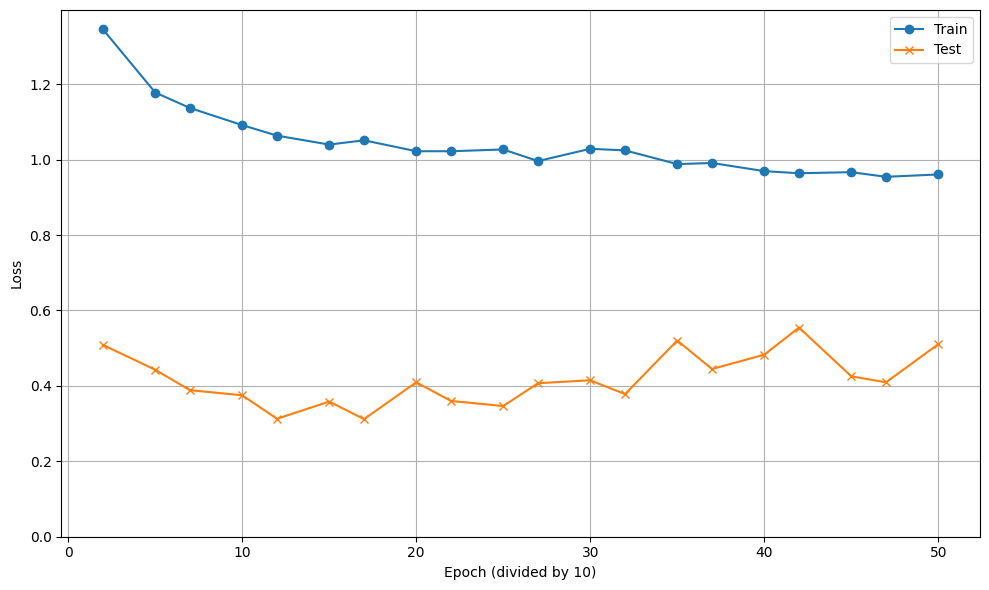

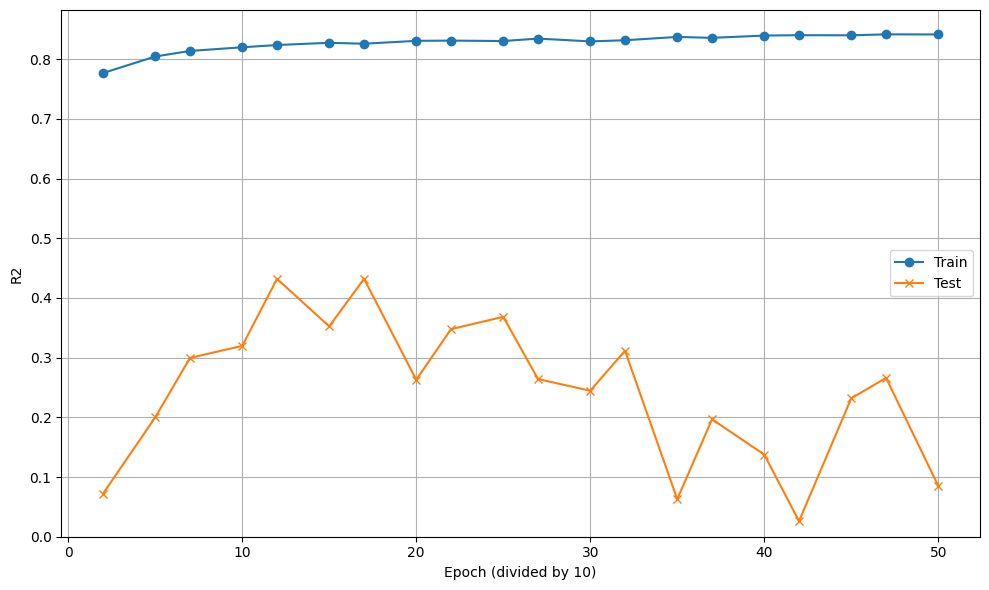

In [ ]:
def plot_training_results(epoch_list, train_list, test_list, metric):
  plt.figure(figsize=(10, 6))
  plt.plot(epoch_list, train_list, label='Train', marker='o')
  plt.plot(epoch_list, test_list, label='Test', marker='x')
  plt.xlabel('Epoch (divided by 10)')
  plt.ylabel(metric)
  plt.ylim(bottom=0)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

plot_training_results(epoch_list, train_loss_list, test_loss_list, 'Loss')
plot_training_results(epoch_list, train_acc_list, test_acc_list, 'R2')

Here is where you can save the model weights:

In [ ]:
torch.save(model.state_dict(), 'GraphSAGE_f_calls.pth')

In [ ]:
model = GraphSAGE(hidden_channels = 64,
                  input_layers = 8,
                  dropout_p = 0.5,
                  aggr = "mean",
                  conv_pool_layers = 1,
                  conv_layers = 2,
                  lin_layers = 1, )
model.load_state_dict(torch.load('GraphSAGE_mean_var.pth', weights_only=True))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
with open("tf.pkl", "rb") as f:
    tf = pickle.load(f)

## Model Performance

This code computes various metrics (R2 score, mean absolute error, mean absolute squared error), and contains functions that plot the actual vs predicted values

In [ ]:
def evalute_model(loader):
  """
  Runs the model through desired dataloader

  Returns:
    y_true (actual values),
    y_pred (predicted values),
    acc (R2 score),
    X (hidden layer embeddings)
  """
  model.eval()
  y_true = []
  y_pred = []
  features = []
  for data in loader:
    data = data.to(device)
    out, h = model(data)
    y_true.append(data.y.flatten().cpu().numpy())
    y_pred.append(out.flatten().cpu().detach().numpy())

    features.append(h.cpu().detach().numpy())

  X = np.concatenate(features)
  y_true = np.concatenate(y_true)
  y_pred = np.concatenate(y_pred)

  return y_true, y_pred, X

def get_metrics(y_true, y_pred):
  R2 = sklearn.metrics.r2_score(y_true, y_pred)
  MAE = sklearn.metrics.mean_absolute_error(y_true, y_pred)
  mean_y_pred = np.mean(y_pred)
  aad = 0
  for y in y_pred:
    aad += np.abs(y - mean_y_pred)
  aad = aad / len(y_pred)
  MASE = aad
  print("R2:", R2)
  print("MAE:", MAE)
  print("MASE:", MASE)
  return R2, MAE, MASE

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred) # alpha represents transparancy
    plt.plot(y_true, y_true, color='#FF0C0C', linestyle='dotted') # Overlay y=x line
    plt.title('GCN: Predicted vs. Actual Values', fontsize=14)
    plt.xlabel('Actual Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.grid(True)
    plt.show()

y_true, y_pred, X = evalute_model(test_loader)
untransformed_y_true = tf.inverse_transform(y_true.reshape(-1, 1)).flatten()
untransformed_y_pred = tf.inverse_transform(y_pred.reshape(-1, 1)).flatten()

In [ ]:
tf.inverse_transform(np.array([[10]]))

array([[7081.]])

### Predictions vs Actual Values

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

x_data = untransformed_y_true
y_data = untransformed_y_pred
x_label = 'Actual Values'
y_label = 'Predicted Values'

font_prop = fm.FontProperties(fname='cmunbmr.ttf') # This can be removed

with plt.style.context('seaborn-v0_8-paper'):
  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=x_data, y=y_data, s=50)
  plt.plot(x_data, x_data, color='#FF0C0C', linestyle='dotted', linewidth=2)

  # if plotting a fitted curve, use linestyle='--', linewidth=3
  # if plotting error bar, use fmt='o', capsize=12, ecolor='black', elinewidth=1
  plt.xlabel(x_label, fontsize=27, fontproperties=font_prop, labelpad=20)
  plt.ylabel(y_label, fontsize=27, fontproperties=font_prop, labelpad=20)
  plt.grid(True, alpha=.25)
  plt.tick_params(axis='both', labelsize=12)
  plt.show()

#plot_predictions(untransformed_y_true, untransformed_y_pred)
get_metrics(untransformed_y_true, untransformed_y_pred);

FileNotFoundError: [Errno 2] No such file or directory: '/content/cmunbmr.ttf'

<Figure size 1000x600 with 1 Axes>

R2: 0.08535033464431763
MAE: 346.6253662109375
MASE: 284.39619535699114


Use the following code to see the perfomance on low y values. Especially useful for mean grad variance where most values are concentrated around zero.

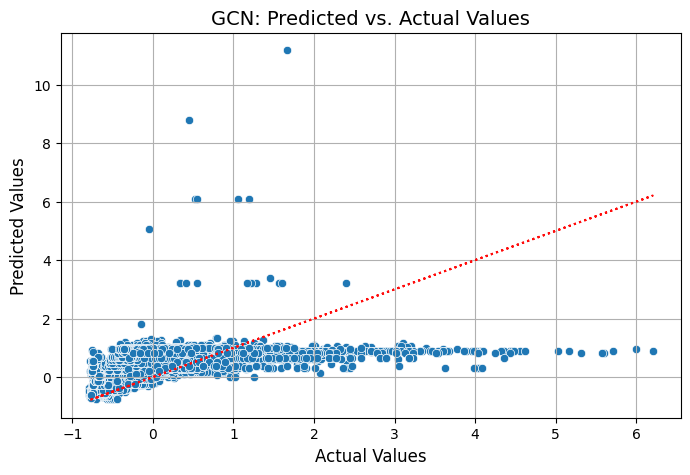

R2: 0.0853503942489624
MAE: 0.5316339731216431
MASE: 0.43619049637408186


In [ ]:
mask = y_true <= 10000

y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

plot_predictions(y_true_filtered, y_pred_filtered)
get_metrics(y_true_filtered, y_pred_filtered);

### Hidden Layer Embeddings

In [ ]:
tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=30)
X_tsen = tsne.fit_transform(X)

In [ ]:
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X)

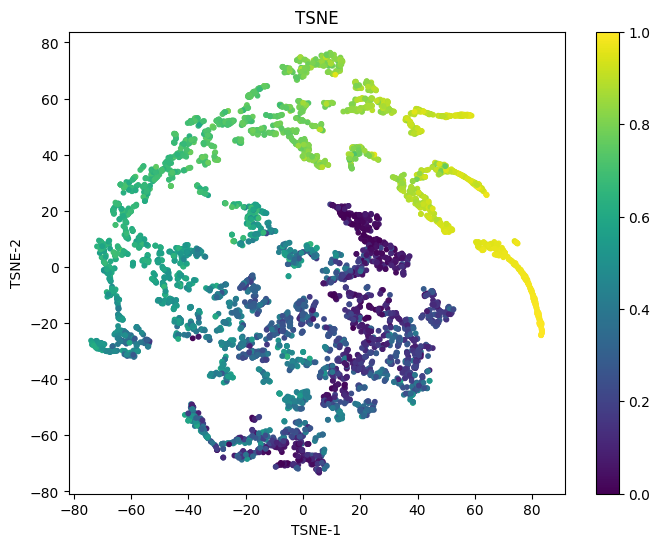

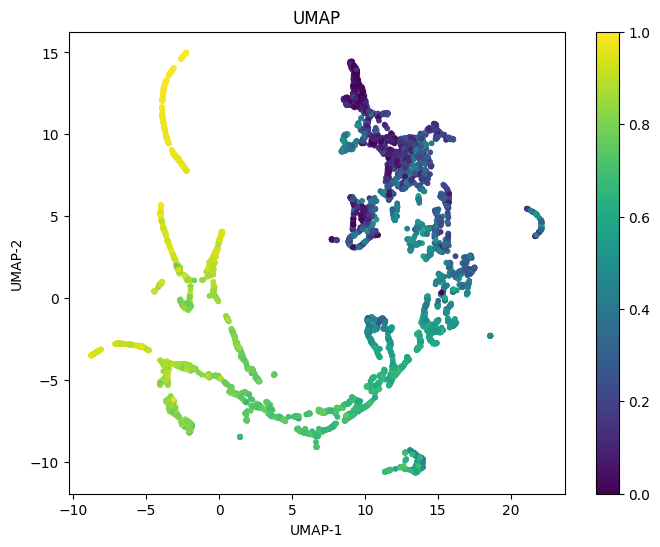

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')
y = qt.fit_transform(y_true.reshape(-1, 1)).ravel()

def plot_embeddings(X_embedded, method):
  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', s=10)
  plt.colorbar(scatter)
  plt.title(method)
  plt.xlabel(method + "-1")
  plt.ylabel(method + "-2")
  plt.show()

plot_embeddings(X_tsen, "TSNE")
plot_embeddings(X_umap, "UMAP")

### Barren Plateau Prediction

Assumes cluster_dataset was loaded in the beginning of the file. This code runs model predictions on all graph in candidate barren plateau clusters, and then plots the model predictions for each cluster. We notice that the model is able to predict exponential behavior accurately. See paper for more details

In [ ]:
from tqdm import tqdm

model.eval()
y_pred = []
N_list = []
for data in tqdm(cluster_loader):
  data = data.to(device)
  out, _ = model(data)
  y_out = out.flatten().cpu().detach().numpy()
  y_pred.append(y_out)
  N_array = data.x.shape[0] * np.ones_like(y_out)

  N_list.append(N_array)

N_values = np.concatenate(N_list)
y_pred = np.concatenate(y_pred)
untransformed_y_pred = tf.inverse_transform(y_pred.reshape(-1, 1)).flatten()

100%|██████████| 18375/18375 [02:52<00:00, 106.53it/s]


In [ ]:
# untransformed_y_pred are the prediction values in list format
# N values are the values of N in list format
# cluster_ids are the cluster ids read from the csv file in list format

clusters = {}

for cid, yp, nv, prl, exp_a, exp_b in zip(cluster_ids, untransformed_y_pred, N_values, cluster_prl, cluster_exp_a, cluster_exp_b):
    if cid not in clusters:
        clusters[cid] = ([], [], prl, exp_a, exp_b)  # y_list, n_list, prl
    clusters[cid][0].append(yp)
    clusters[cid][1].append(nv)

big_list = [(cid, y_list, n_list, prl, exp_a, exp_b) for cid, (y_list, n_list, prl, exp_a, exp_b) in clusters.items()]

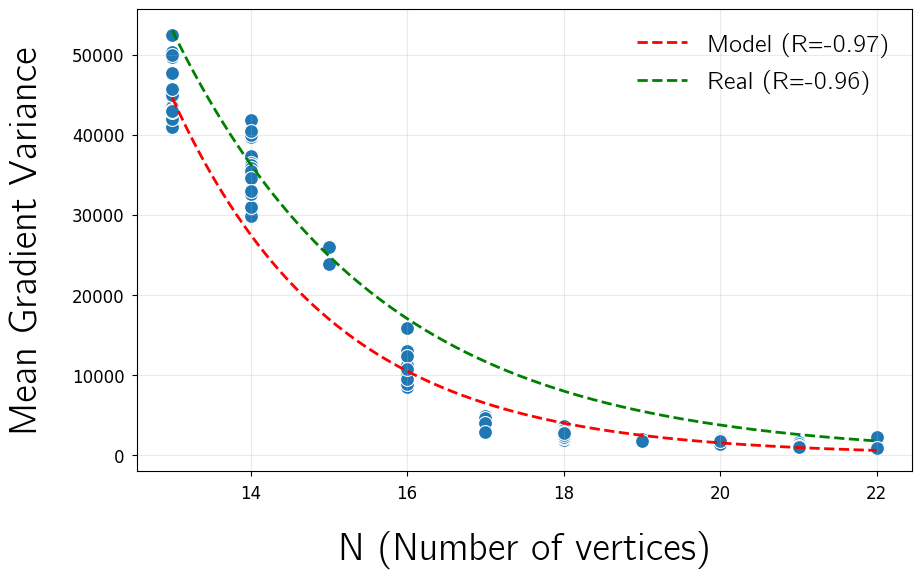

Mean harmonic centrality cluster_2 p = 1


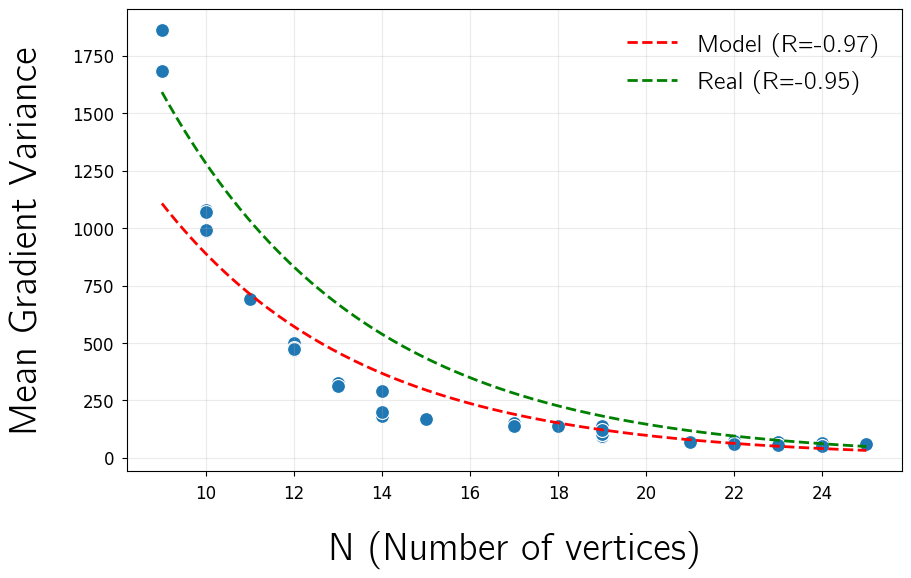

Number of edges val_34 p = 3


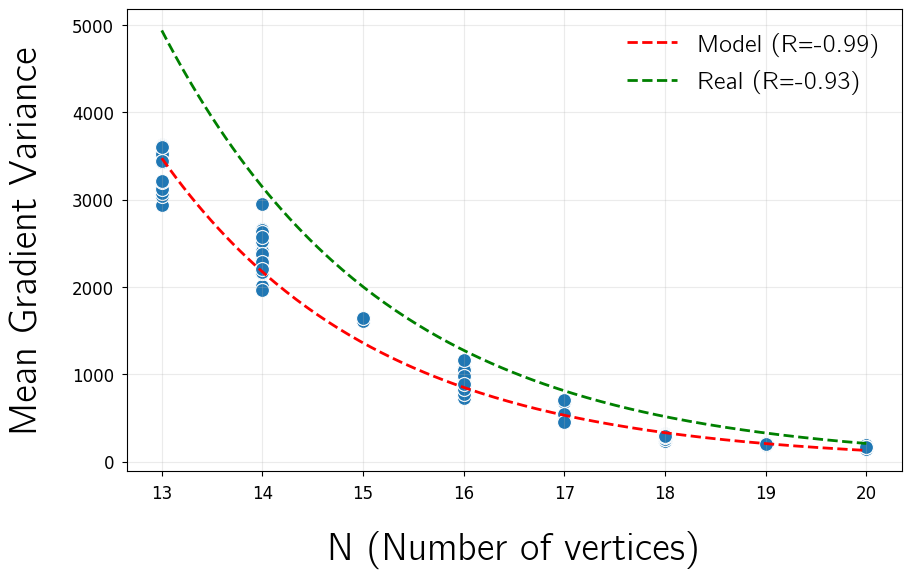

Mean harmonic centrality cluster_1 p = 5


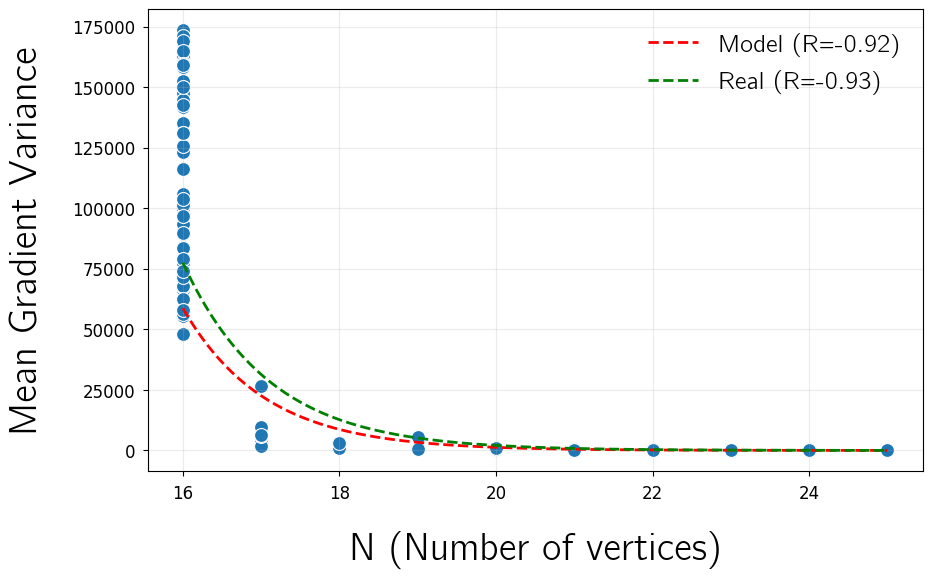

Von Neumann entropy cluster_12 p = 1


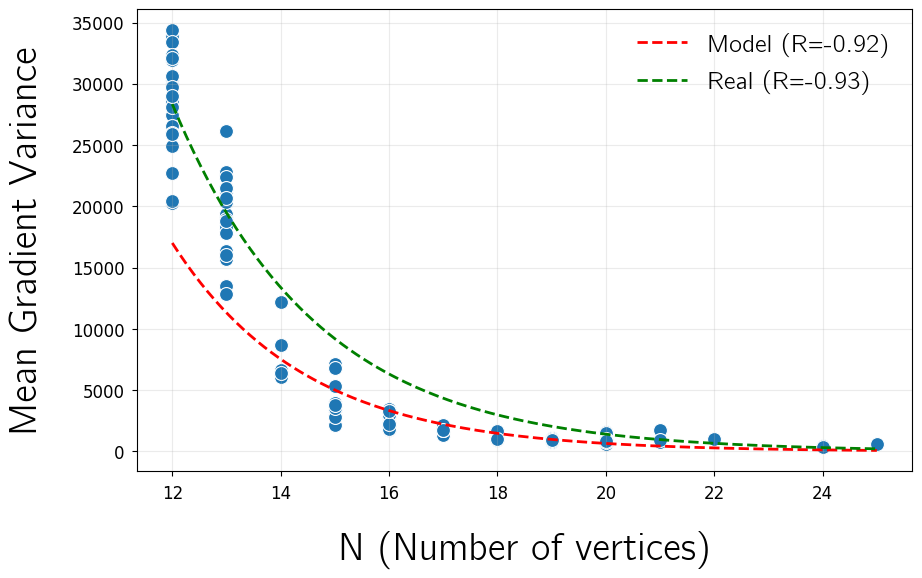

Mean harmonic centrality cluster_7 p = 1


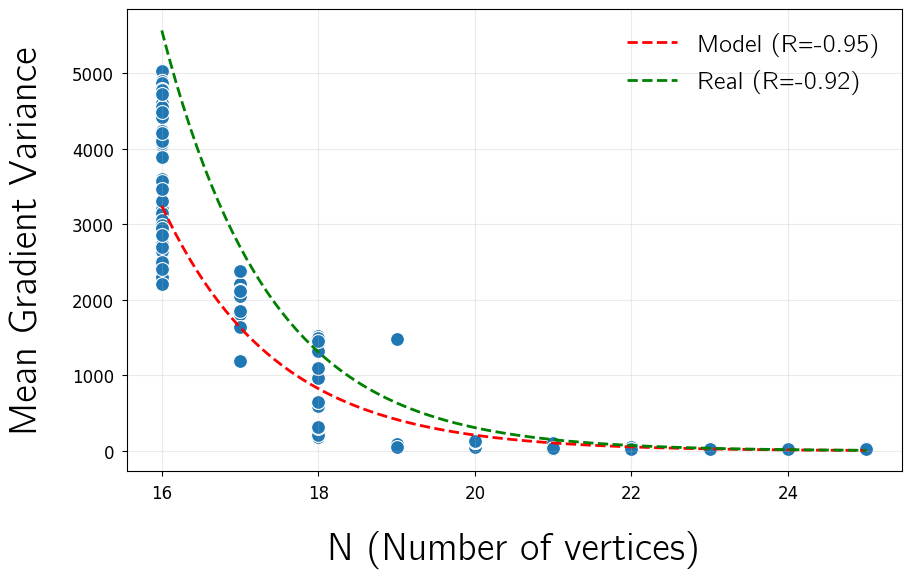

Von Neumann entropy cluster_12 p = 3


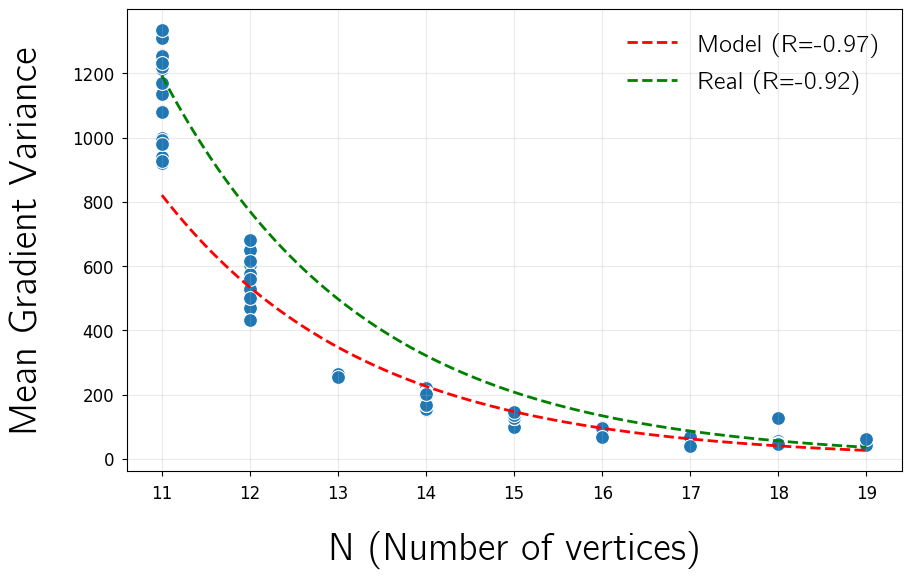

Mean harmonic centrality cluster_6 p = 5


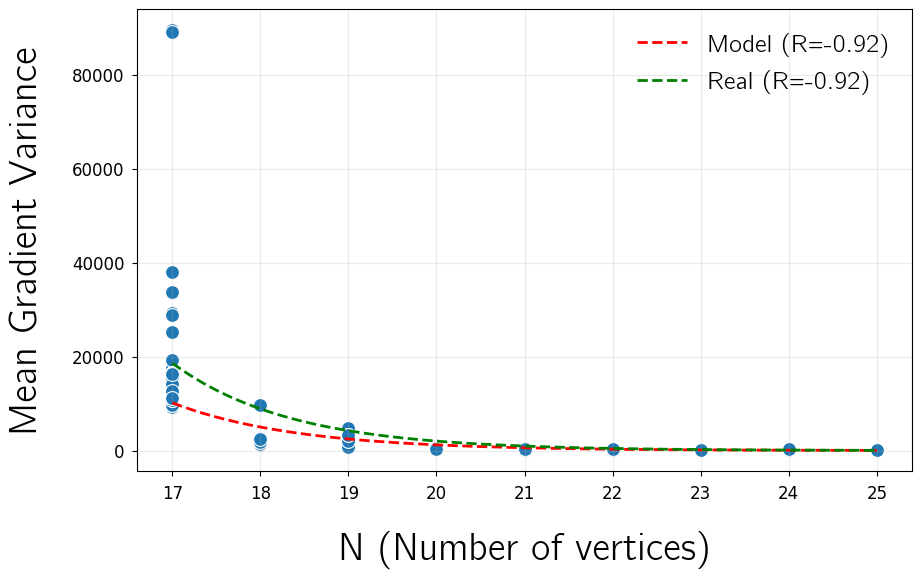

Von Neumann entropy cluster_13 p = 1


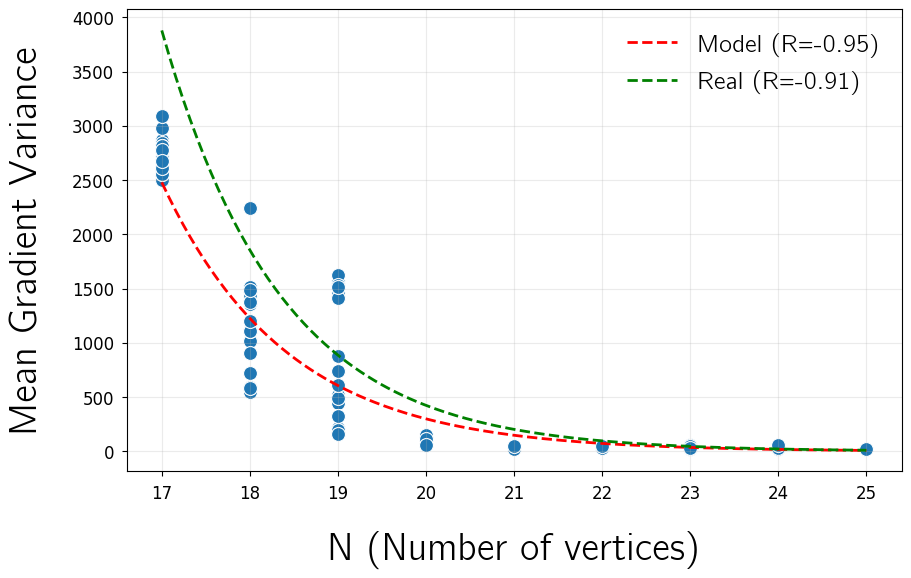

Von Neumann entropy cluster_13 p = 3


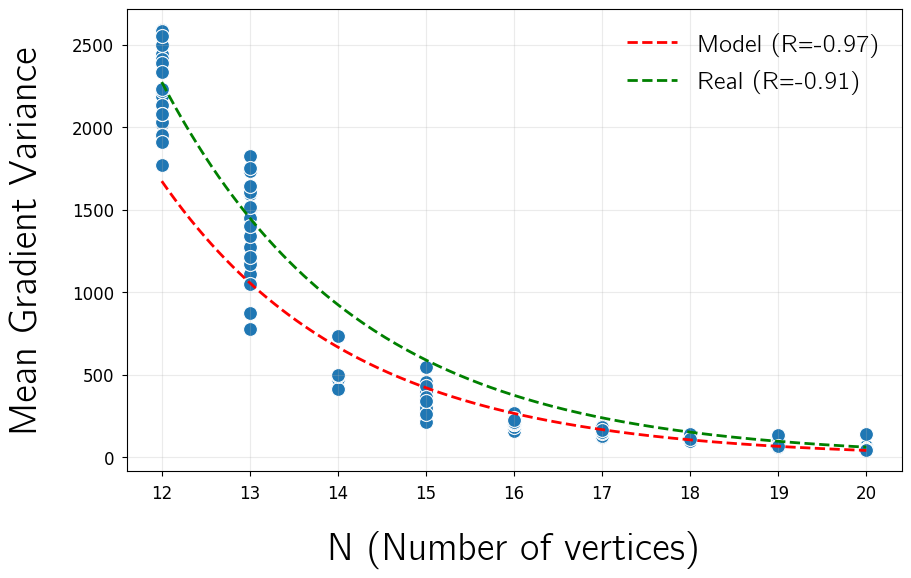

Mean harmonic centrality cluster_8 p = 5


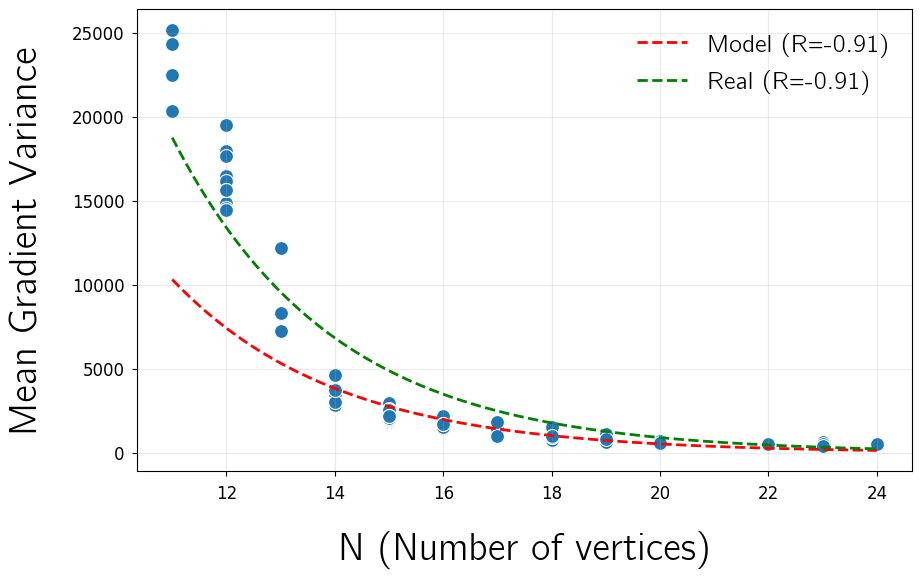

Mean harmonic centrality cluster_6 p = 1


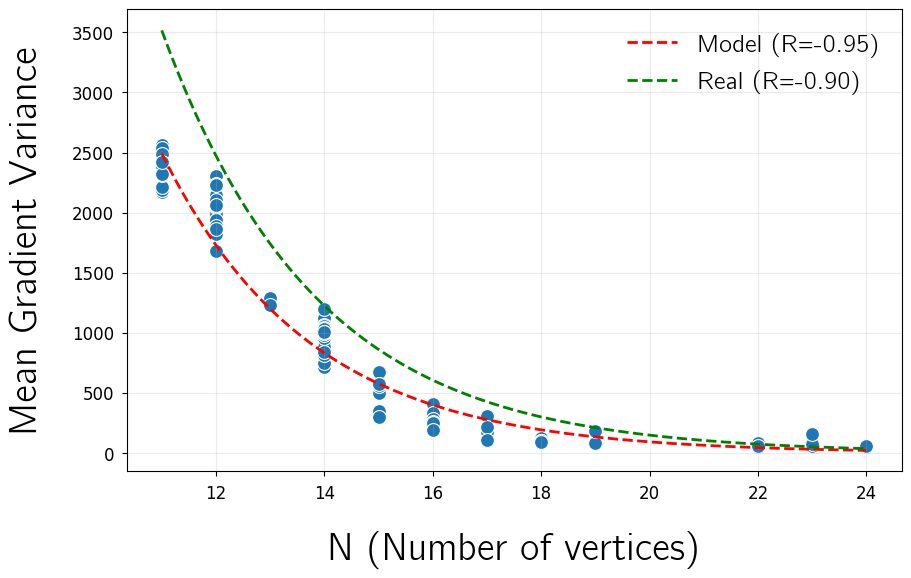

Mean harmonic centrality cluster_5 p = 3


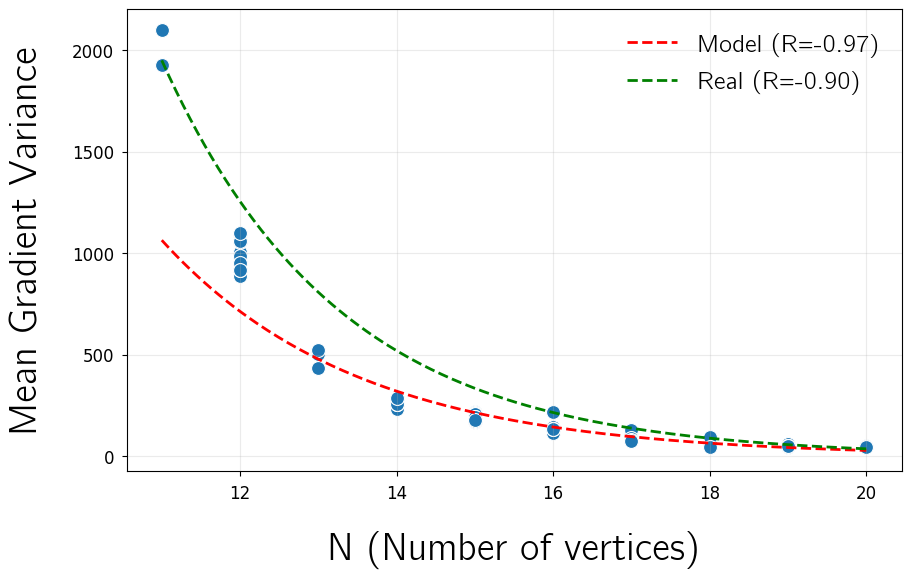

Mean harmonic centrality cluster_7 p = 5


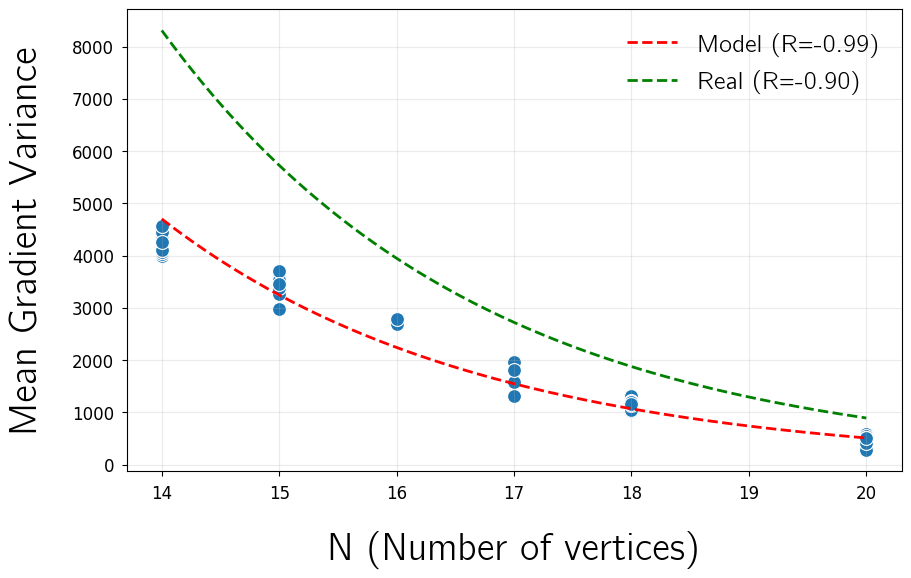

Mean harmonic centrality cluster_3 p = 5


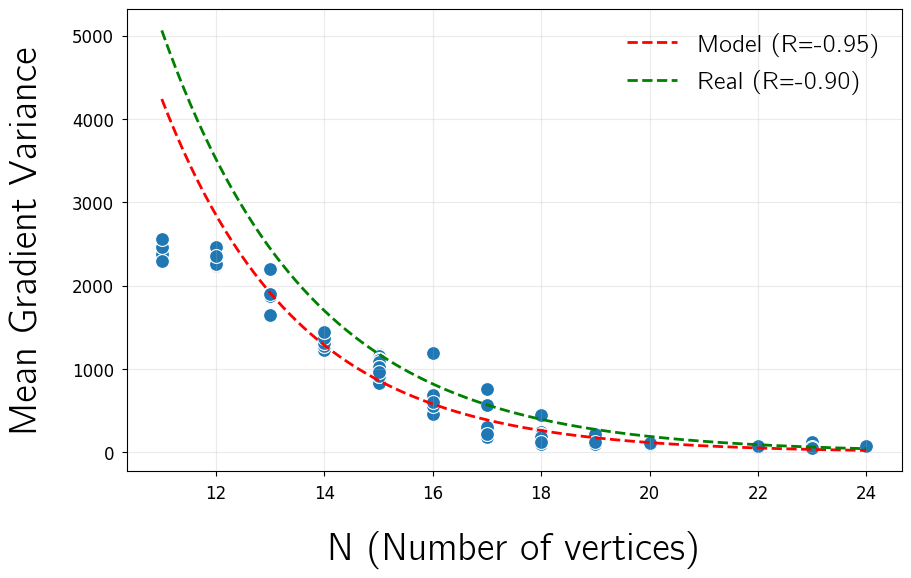

Mean harmonic centrality cluster_6 p = 3


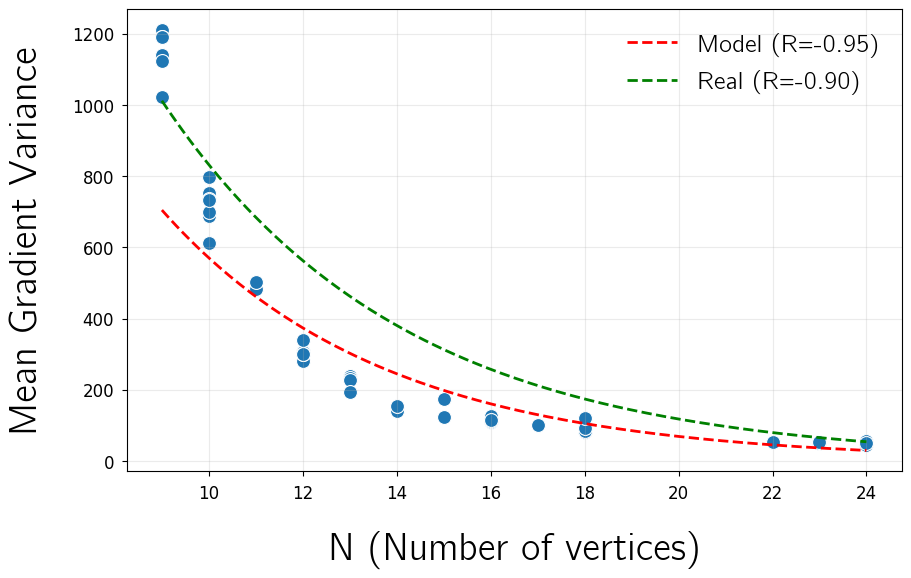

Number of edges val_32 p = 3


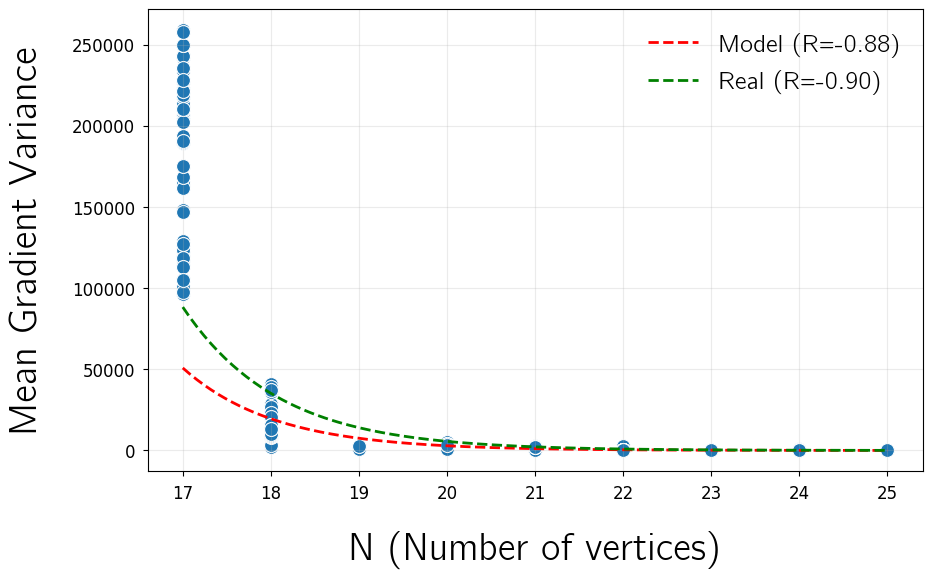

Von Neumann entropy cluster_14 p = 1


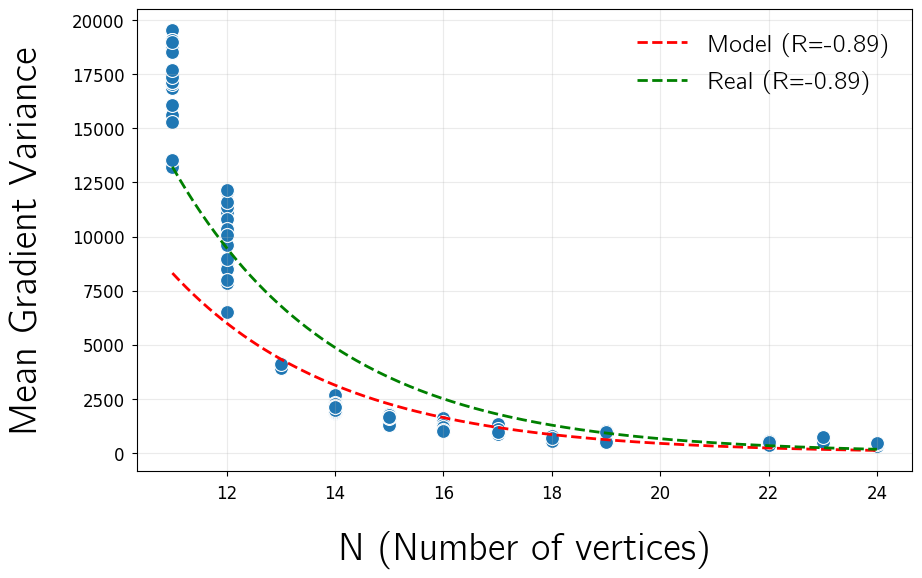

Mean harmonic centrality cluster_5 p = 1


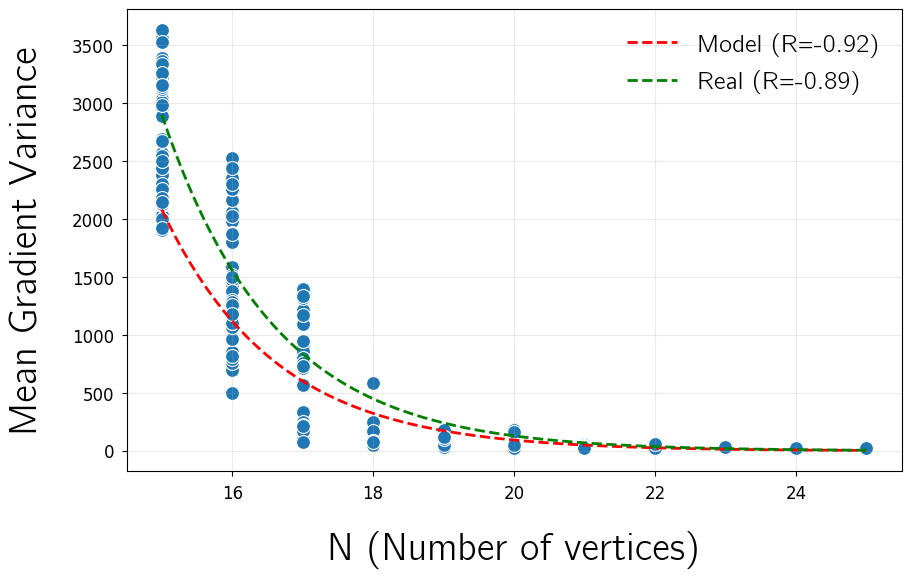

Von Neumann entropy cluster_8 p = 3


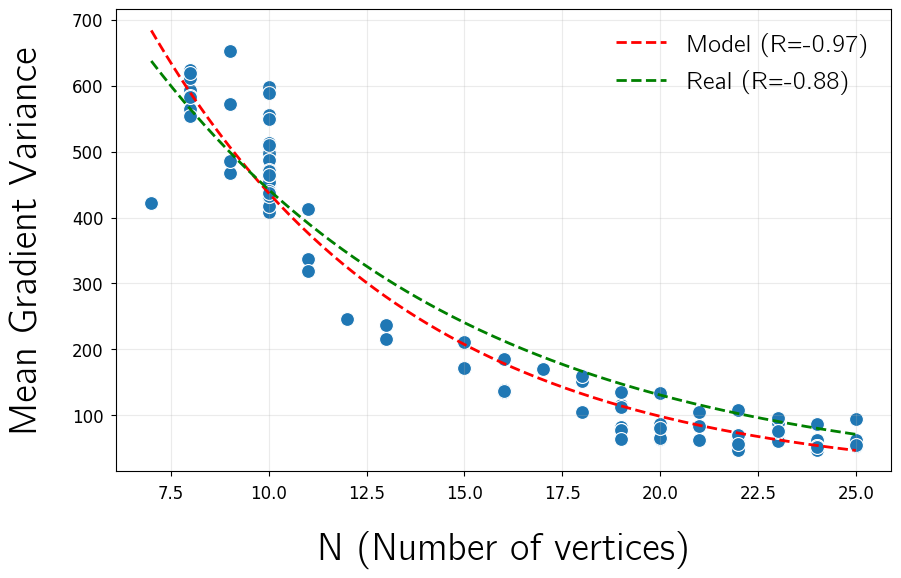

Number of edges val_21 p = 1


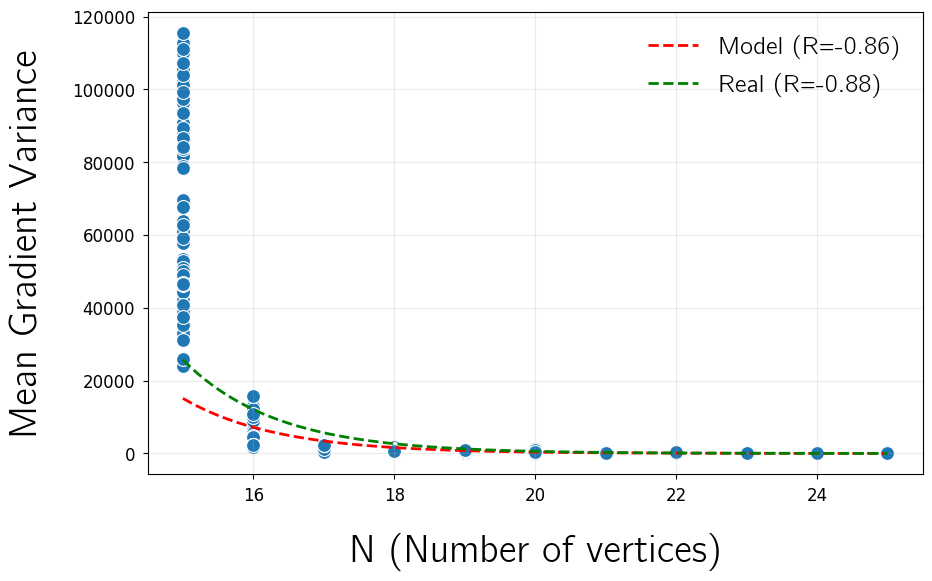

Von Neumann entropy cluster_8 p = 1


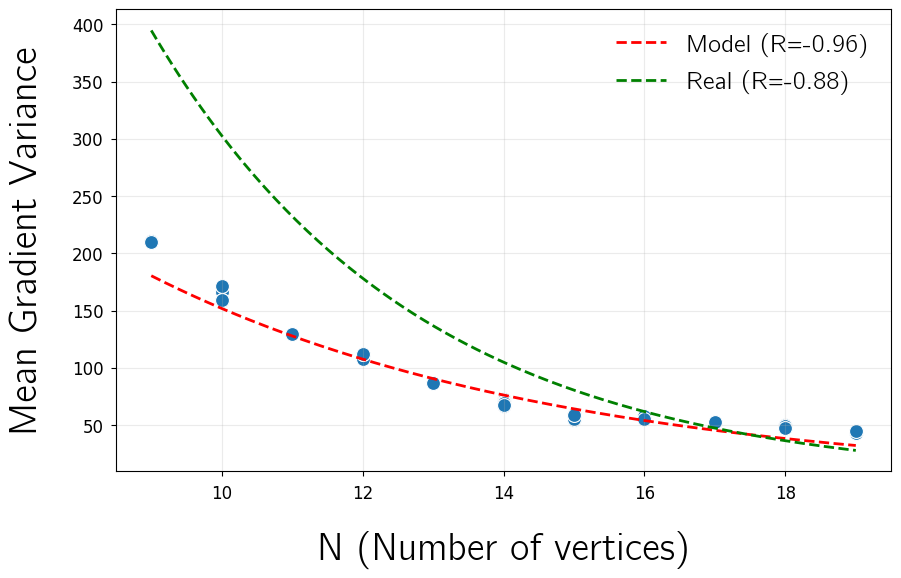

Number of edges val_33 p = 5


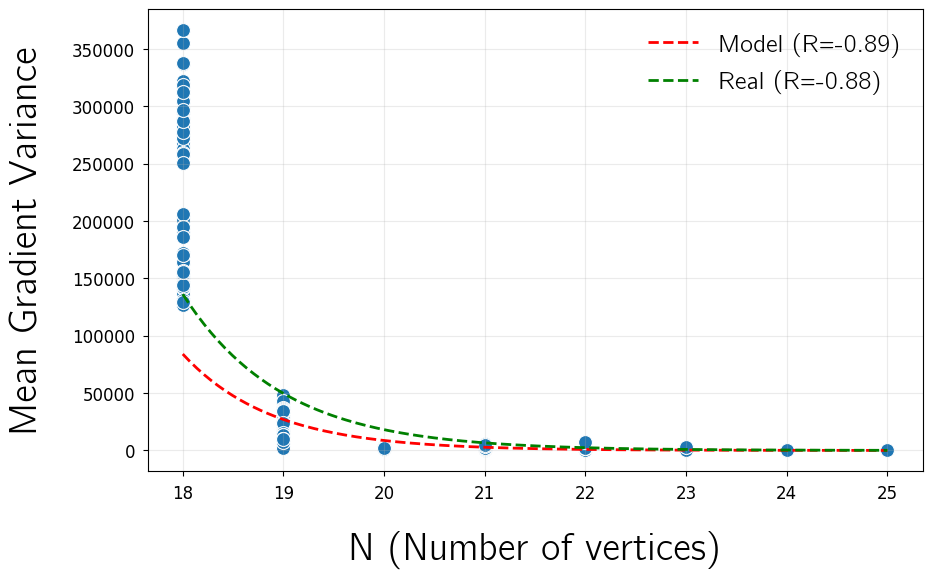

Von Neumann entropy cluster_16 p = 1


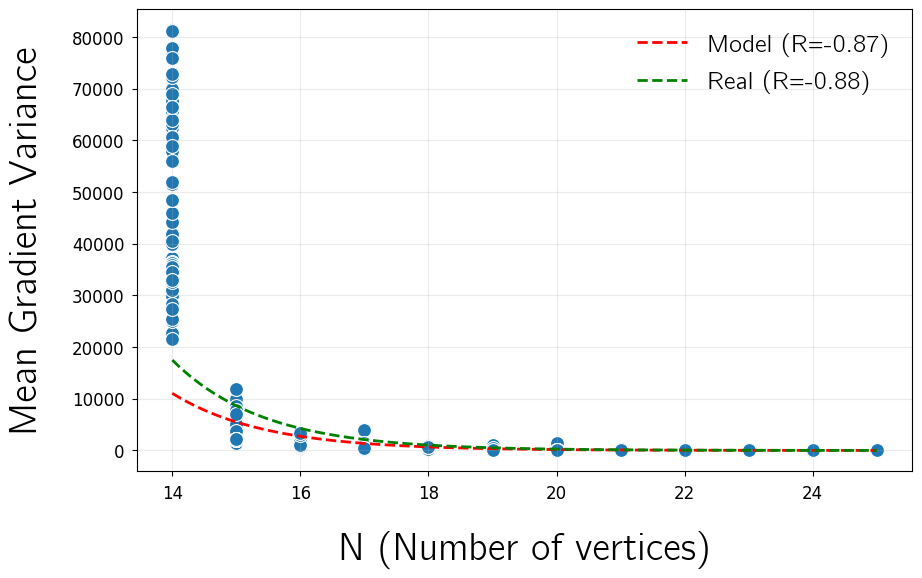

Von Neumann entropy cluster_7 p = 1


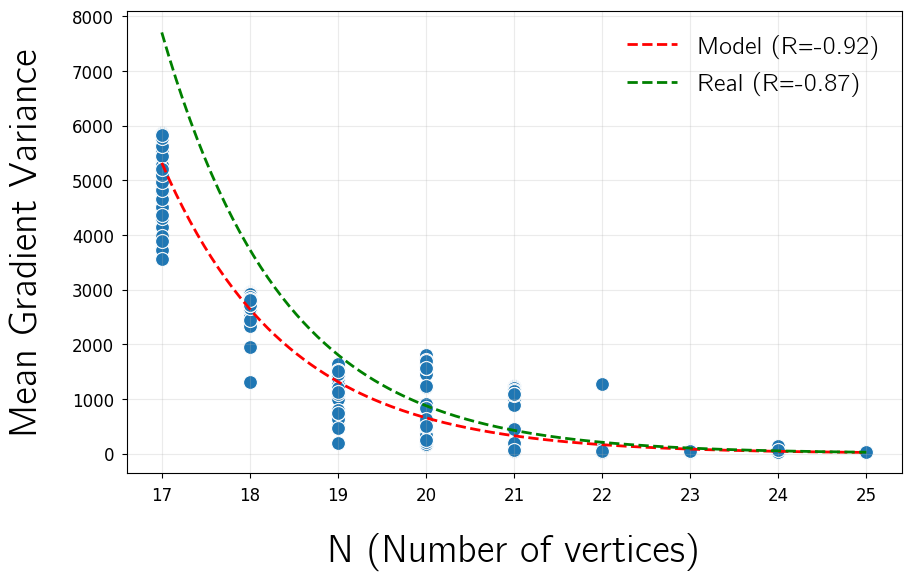

Von Neumann entropy cluster_14 p = 3


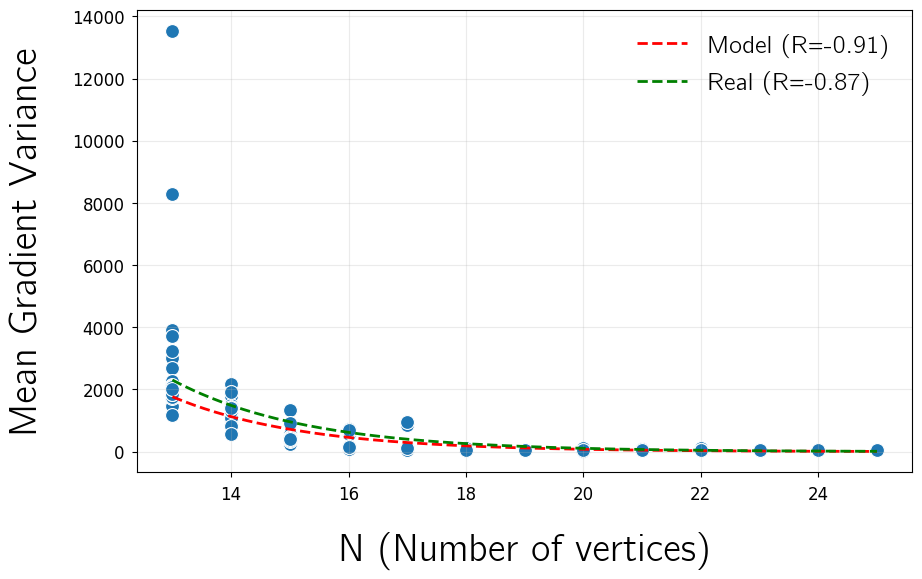

Von Neumann entropy cluster_11 p = 1


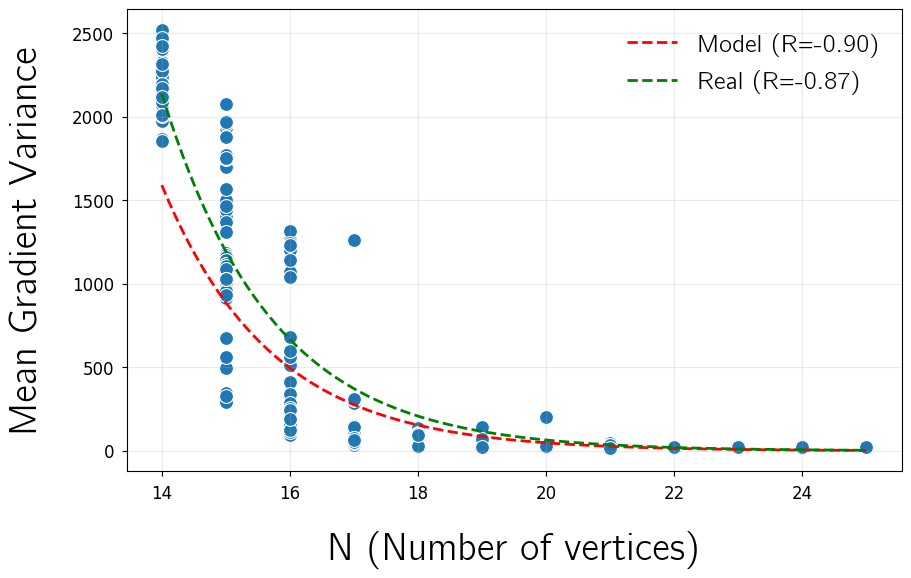

Von Neumann entropy cluster_7 p = 3


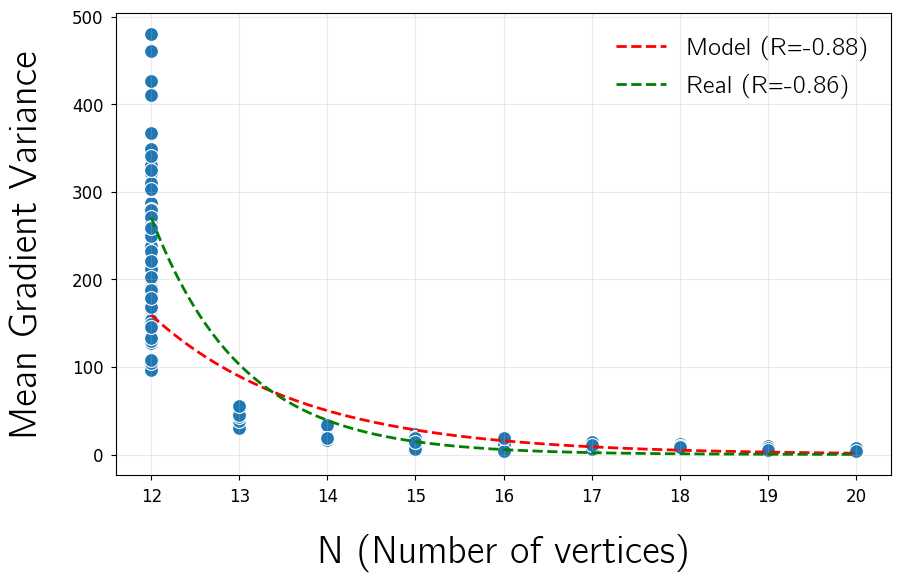

Von Neumann entropy cluster_12 p = 10


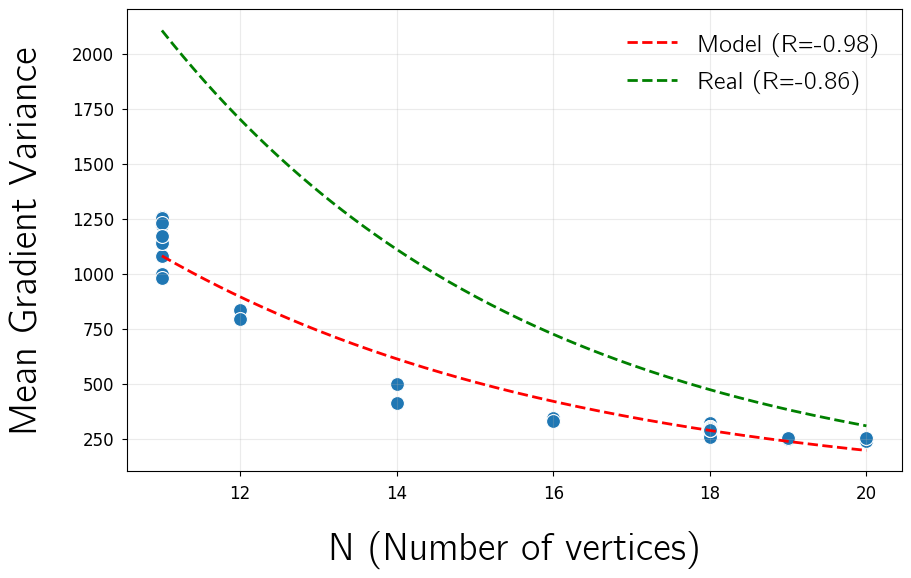

Circuit rank val_39 p = 5


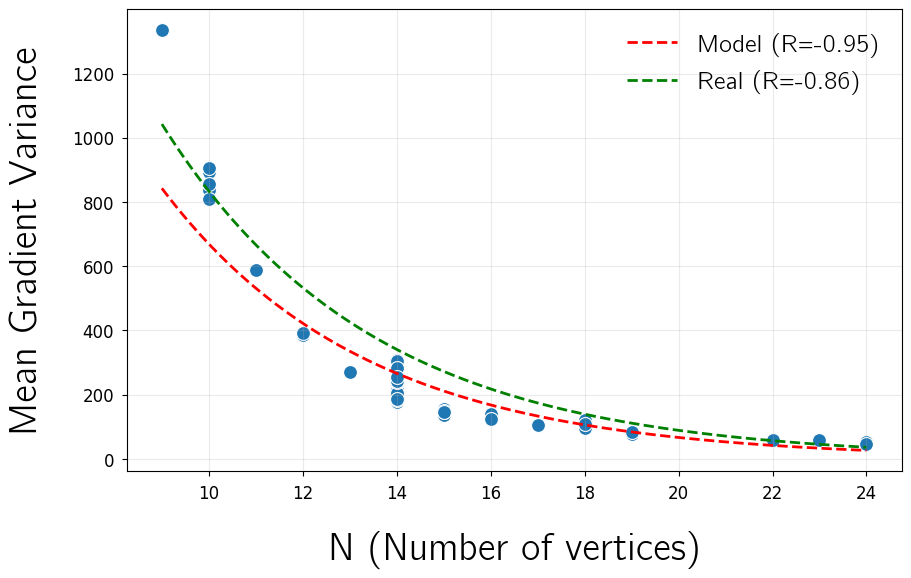

Number of edges val_33 p = 3


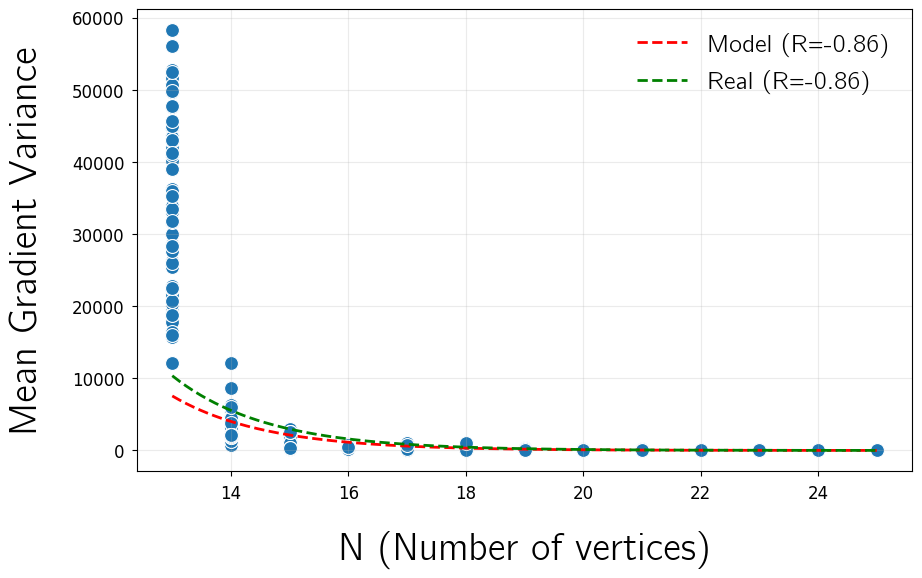

Von Neumann entropy cluster_9 p = 1


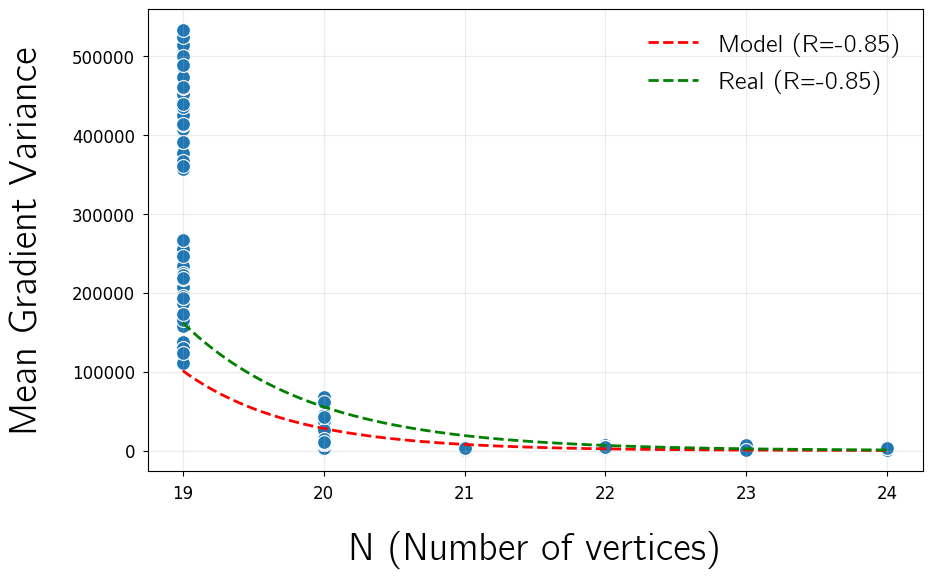

Von Neumann entropy cluster_17 p = 1


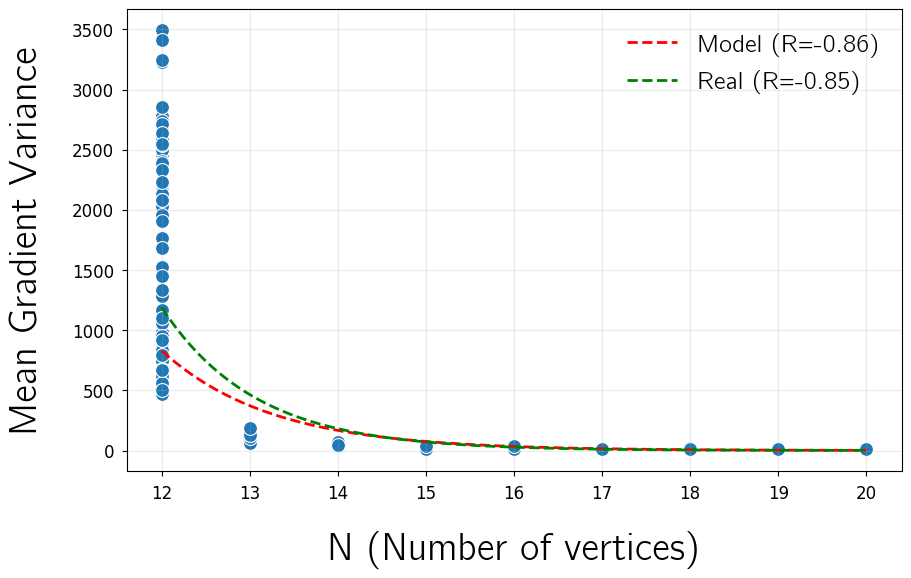

Von Neumann entropy cluster_15 p = 5


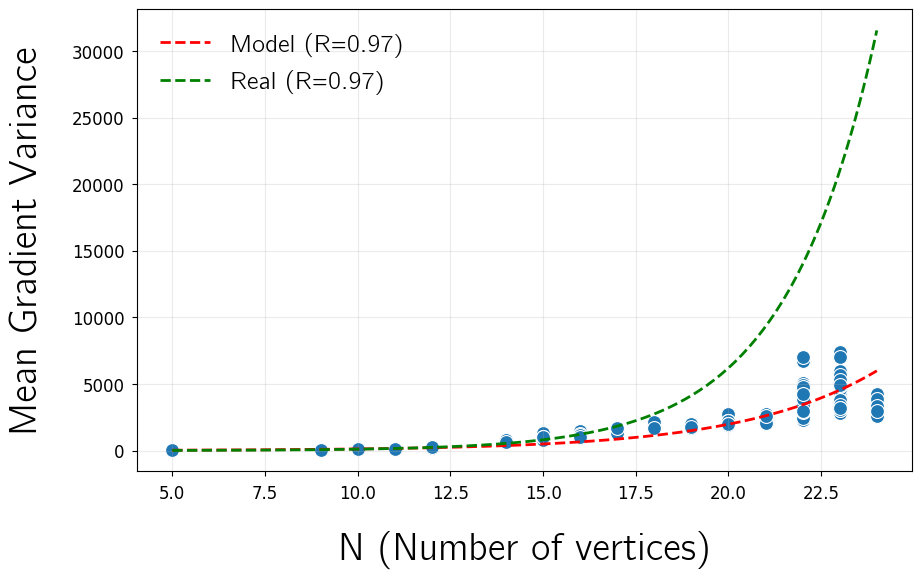

Edge density cluster_15 p = 1


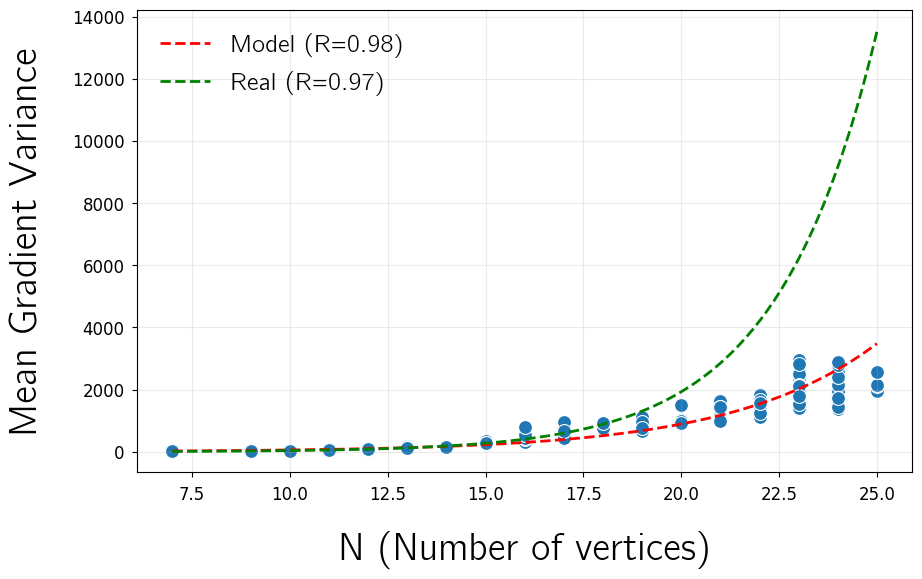

Edge density cluster_18 p = 1


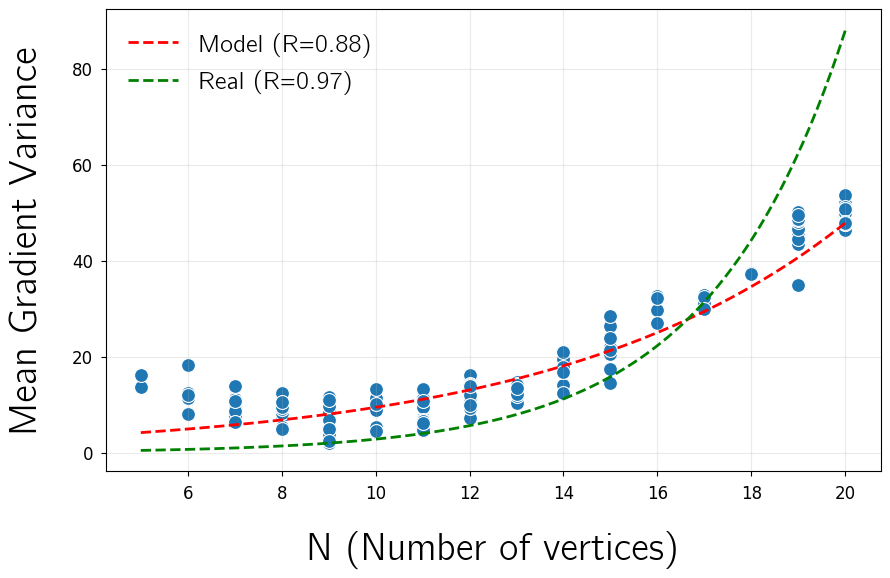

Edge density cluster_18 p = 5


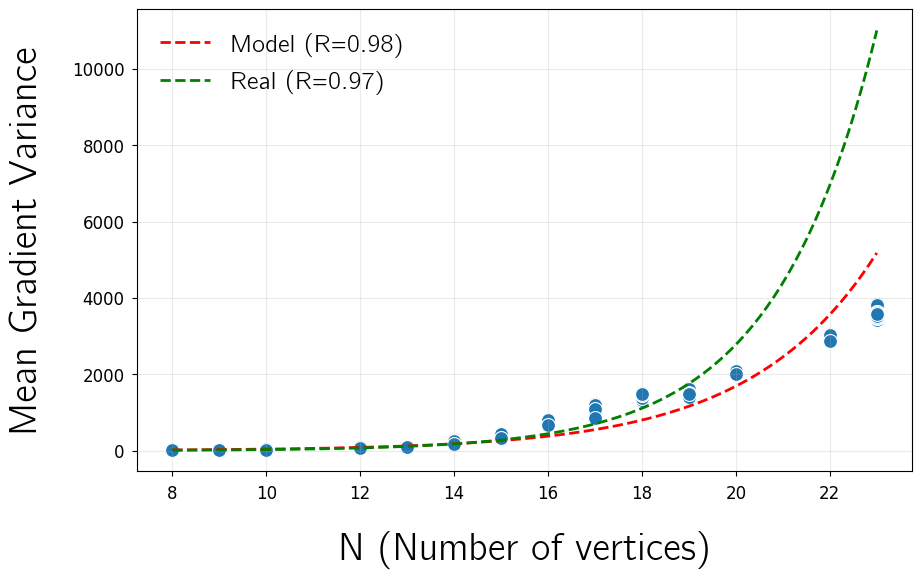

Edge density cluster_3 p = 3


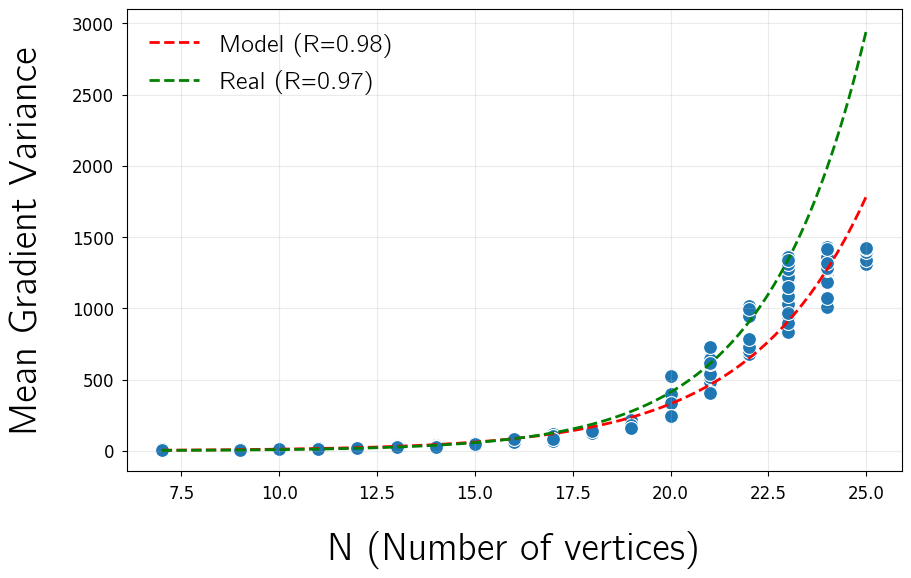

Edge density cluster_18 p = 3


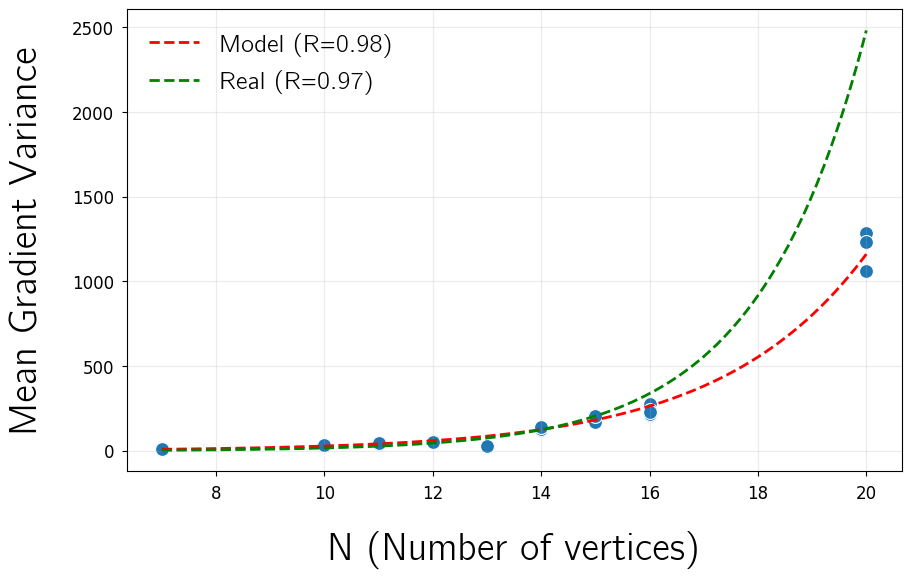

Average path length cluster_13 p = 5


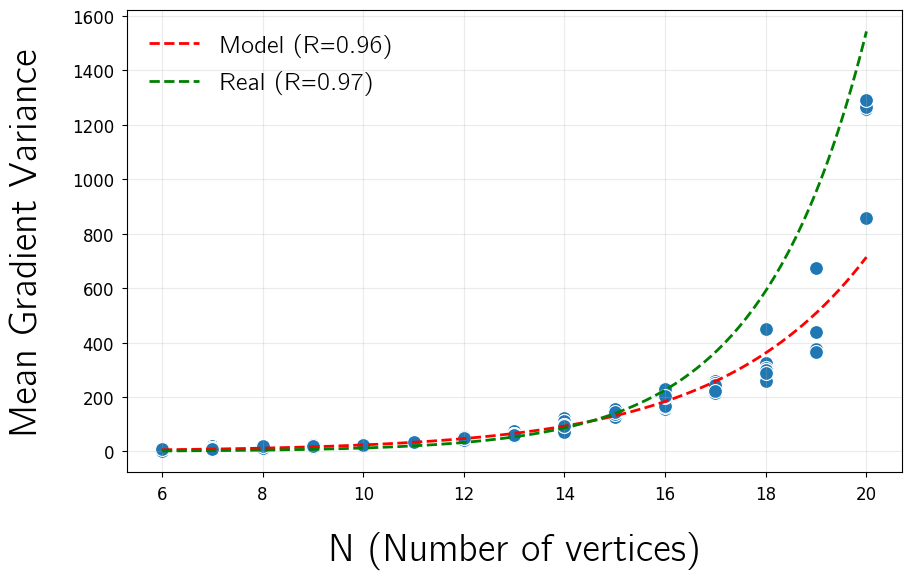

Harmonic diameter cluster_12 p = 5


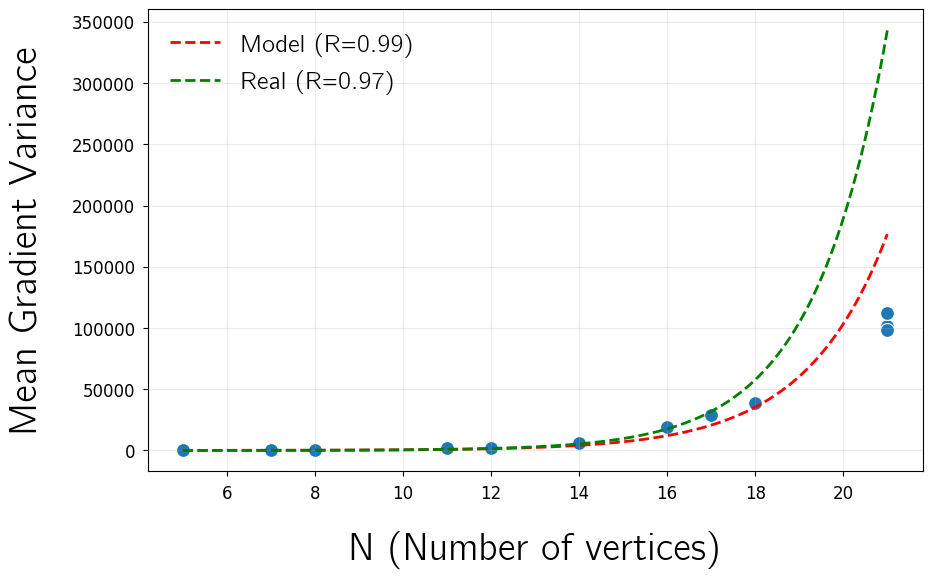

Harmonic diameter cluster_5 p = 1


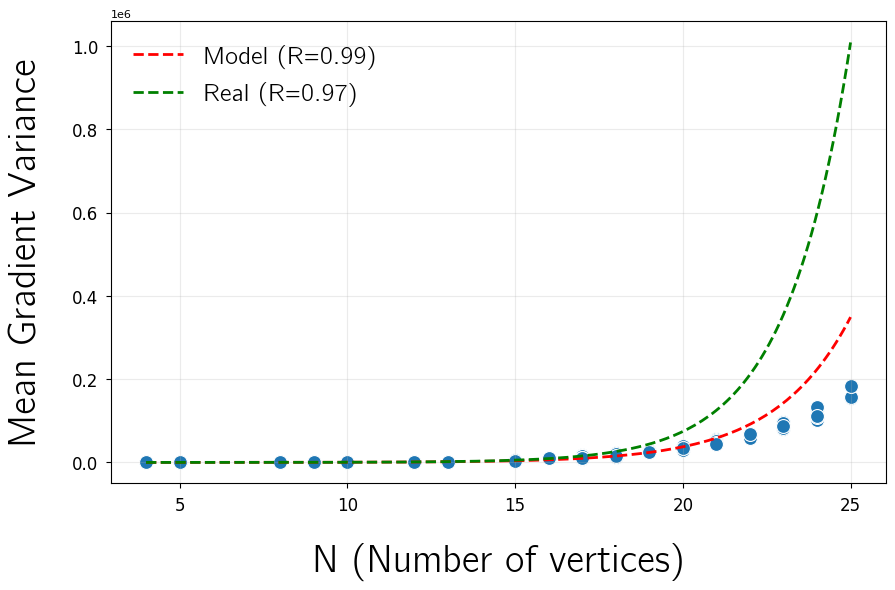

Edge density cluster_11 p = 1


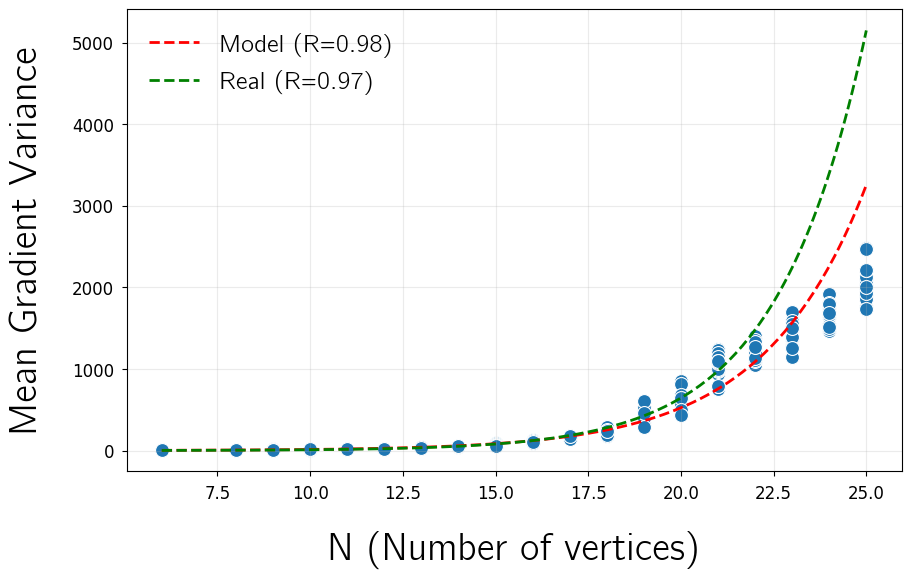

Edge density cluster_17 p = 3


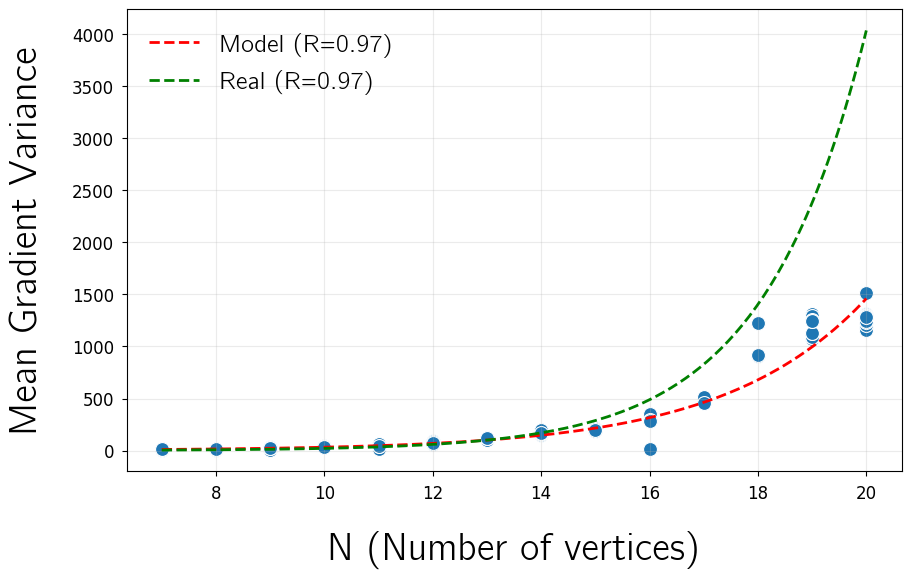

Average path length cluster_11 p = 5


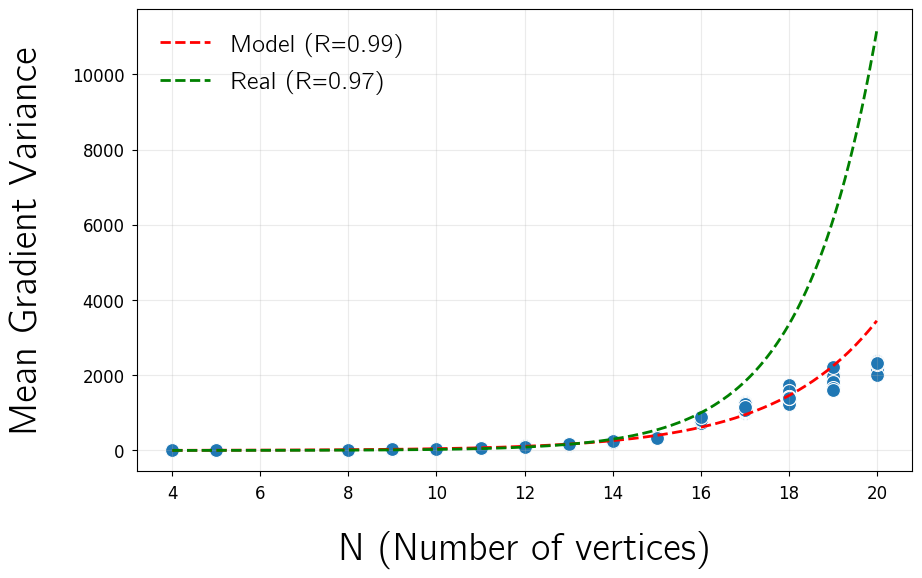

Edge density cluster_6 p = 5


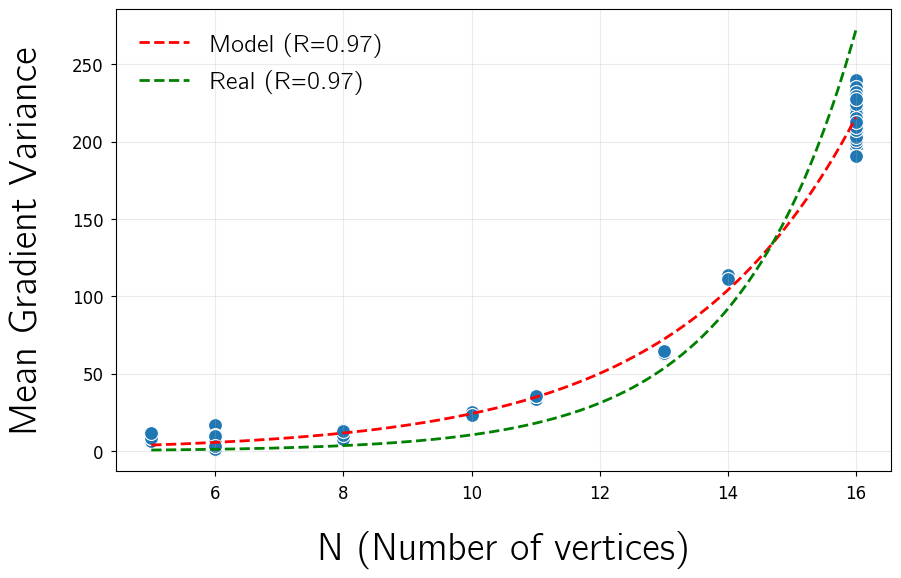

Edge density cluster_7 p = 5


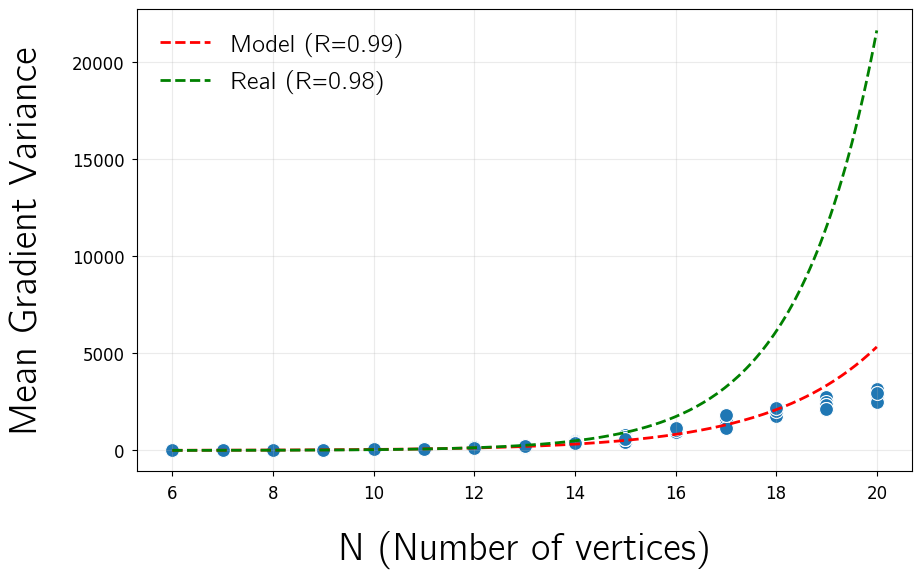

Harmonic diameter cluster_9 p = 5


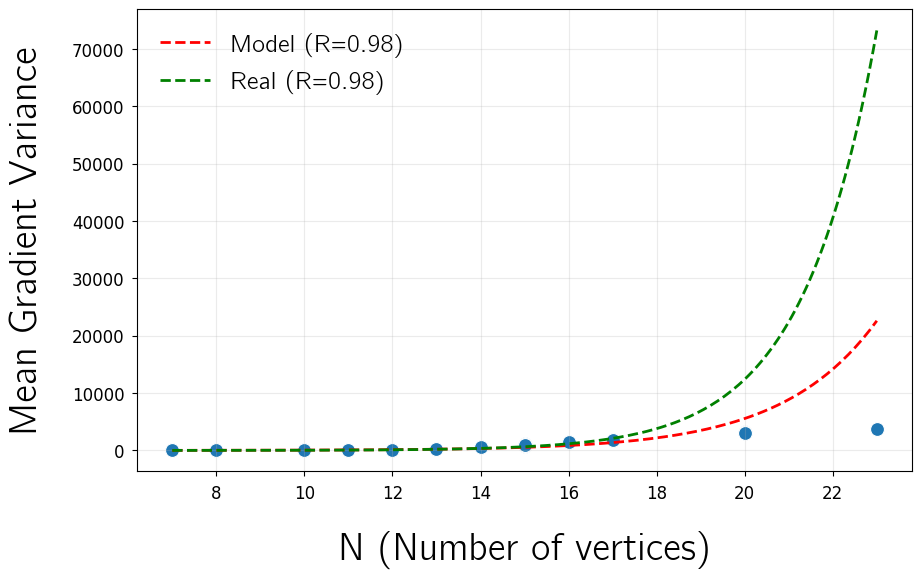

Edge density cluster_9 p = 3


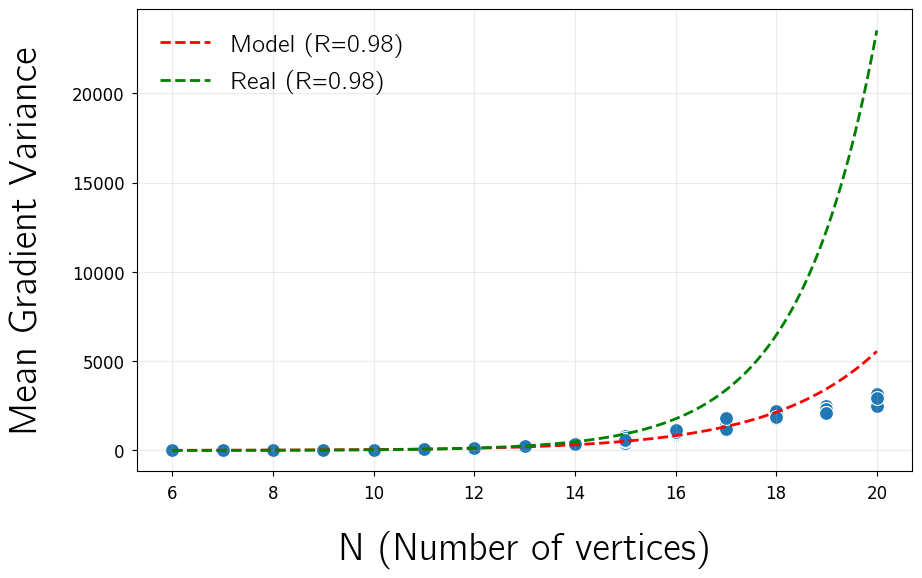

Edge density cluster_5 p = 5


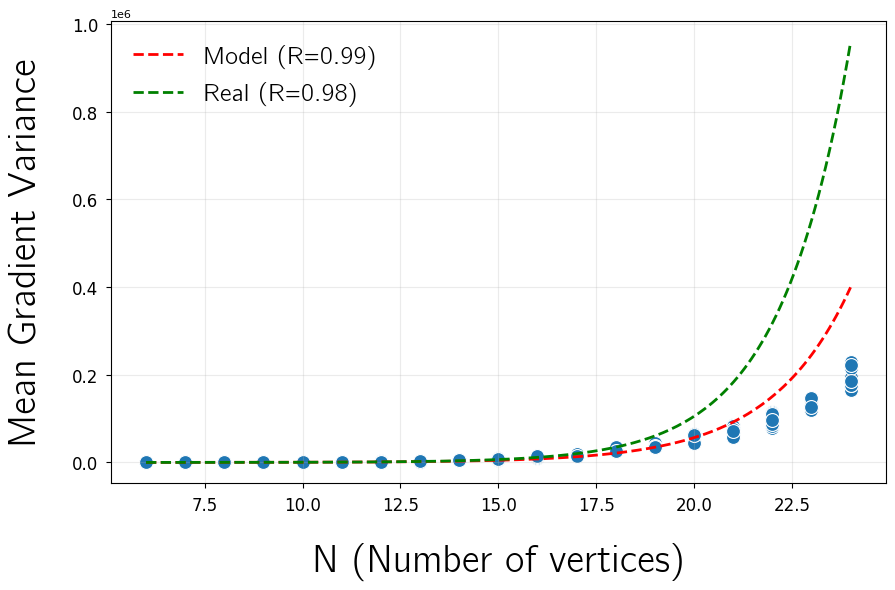

Edge density cluster_7 p = 1


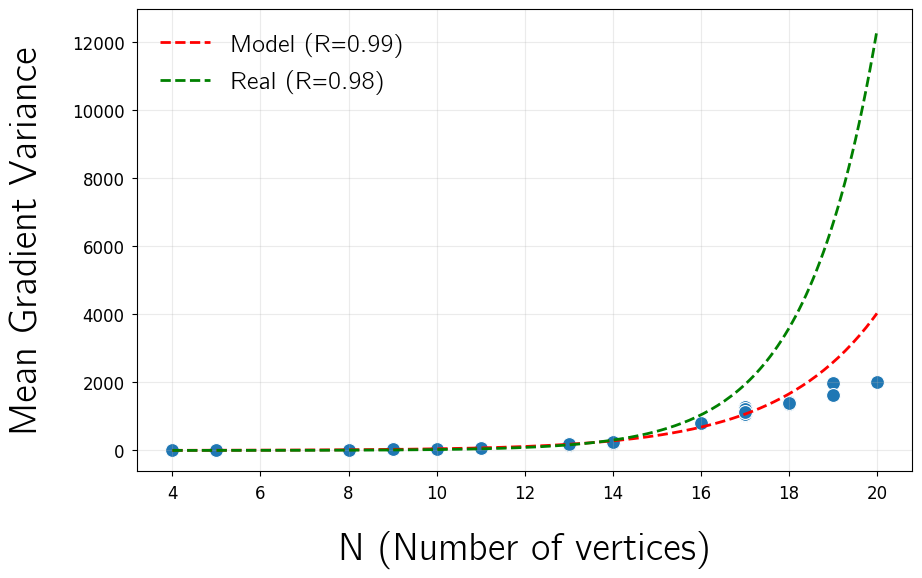

Harmonic diameter cluster_10 p = 5


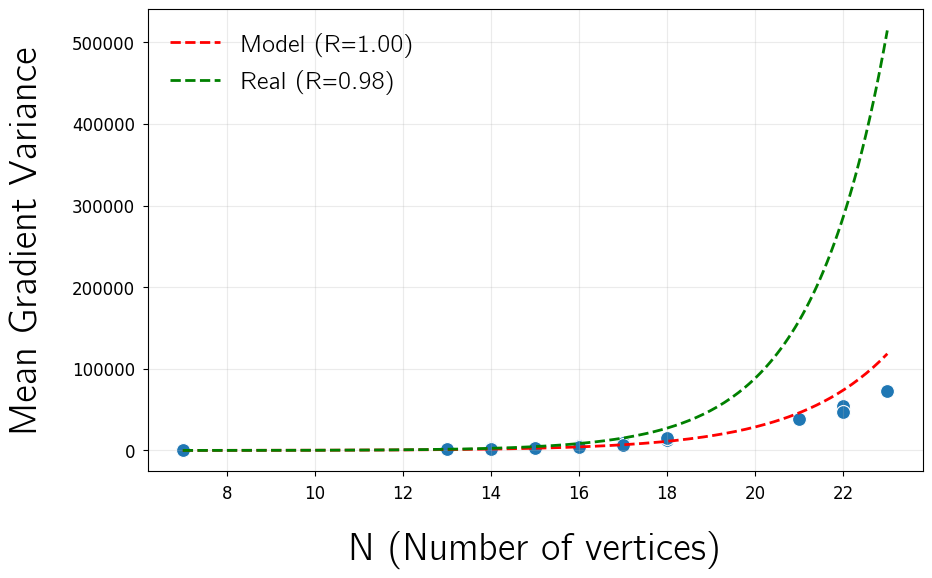

Edge density cluster_13 p = 1


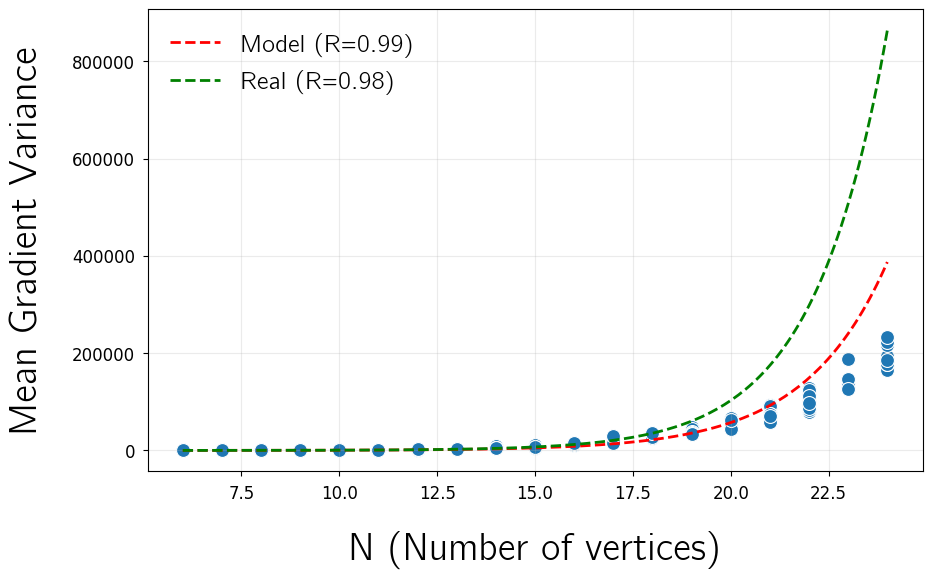

Harmonic diameter cluster_6 p = 1


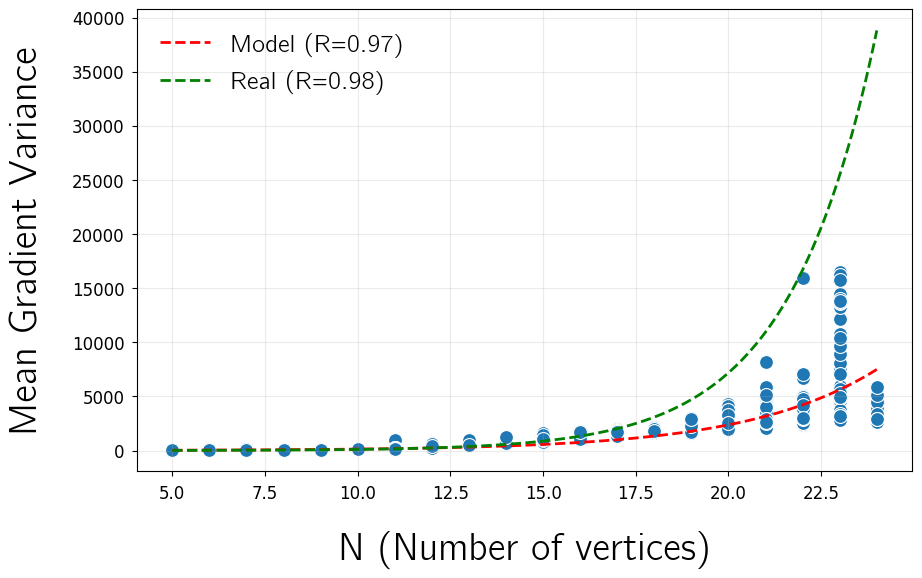

Harmonic diameter cluster_4 p = 1


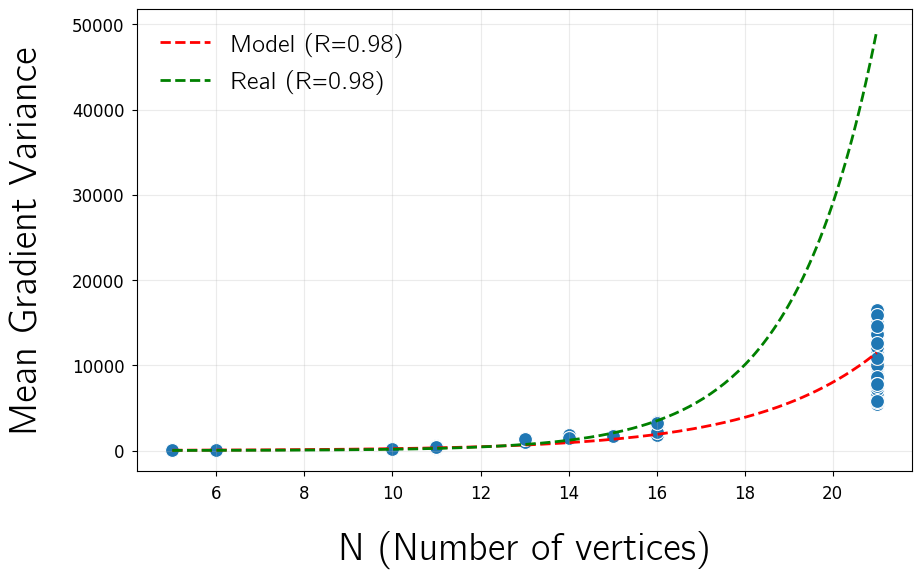

Edge density cluster_4 p = 1


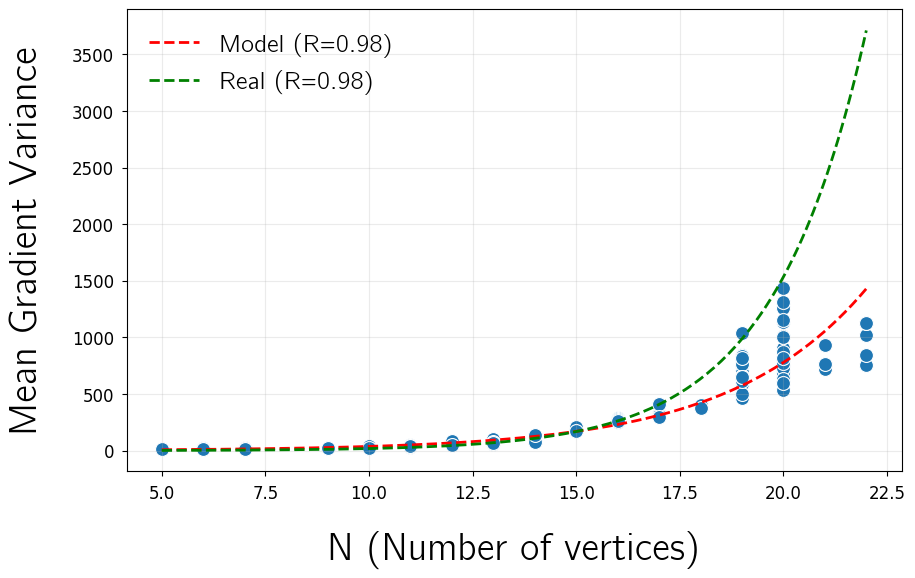

Edge density cluster_10 p = 1


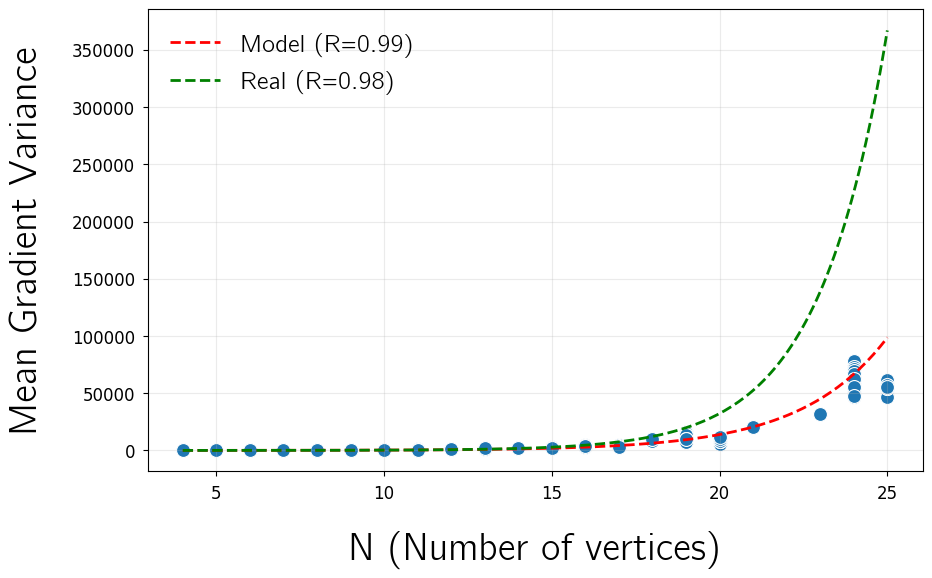

Harmonic diameter cluster_10 p = 1


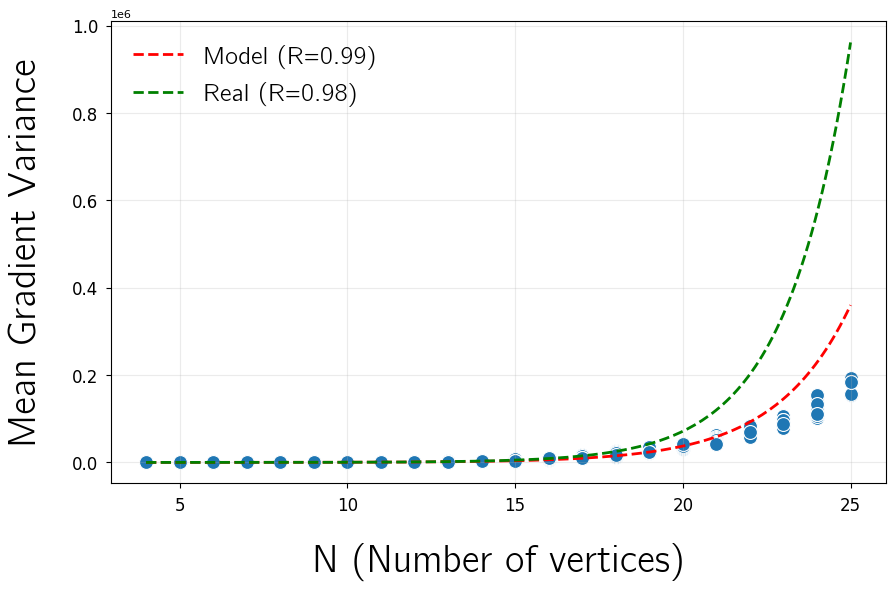

Harmonic diameter cluster_7 p = 1


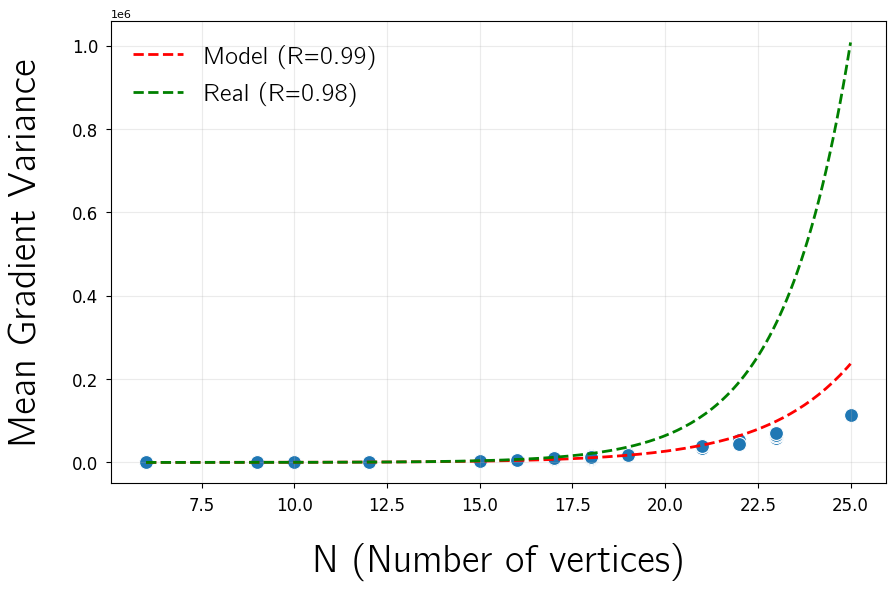

Edge density cluster_14 p = 1


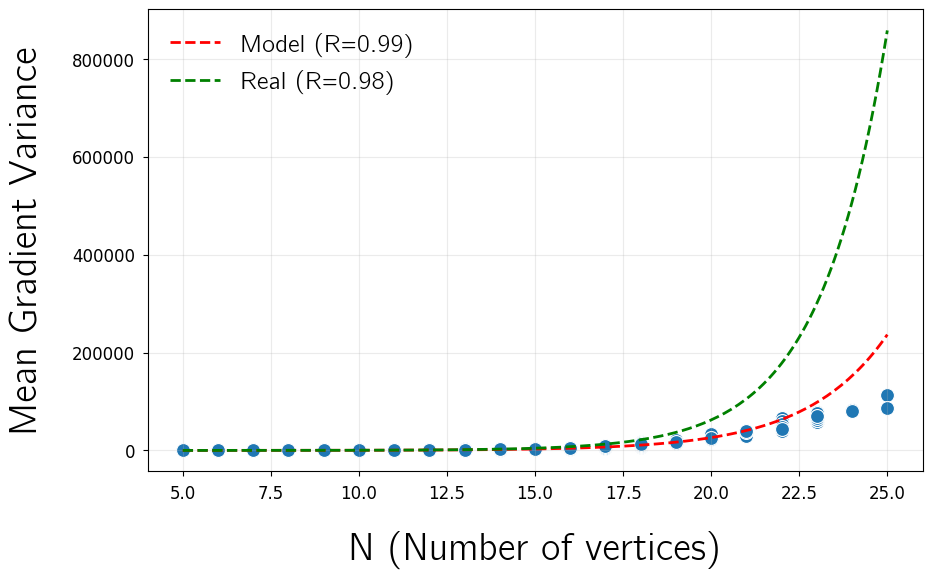

Harmonic diameter cluster_9 p = 1


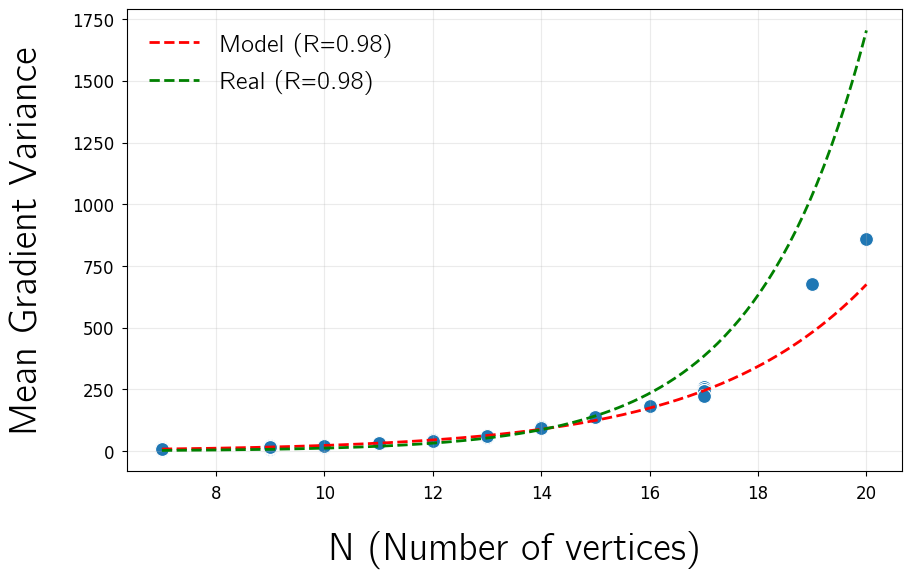

Edge density cluster_8 p = 5


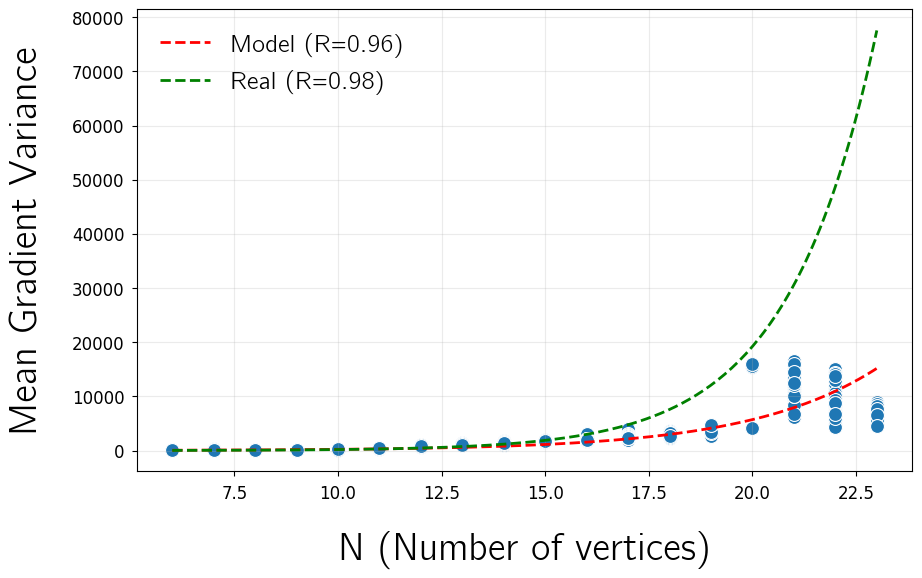

Harmonic diameter cluster_8 p = 1


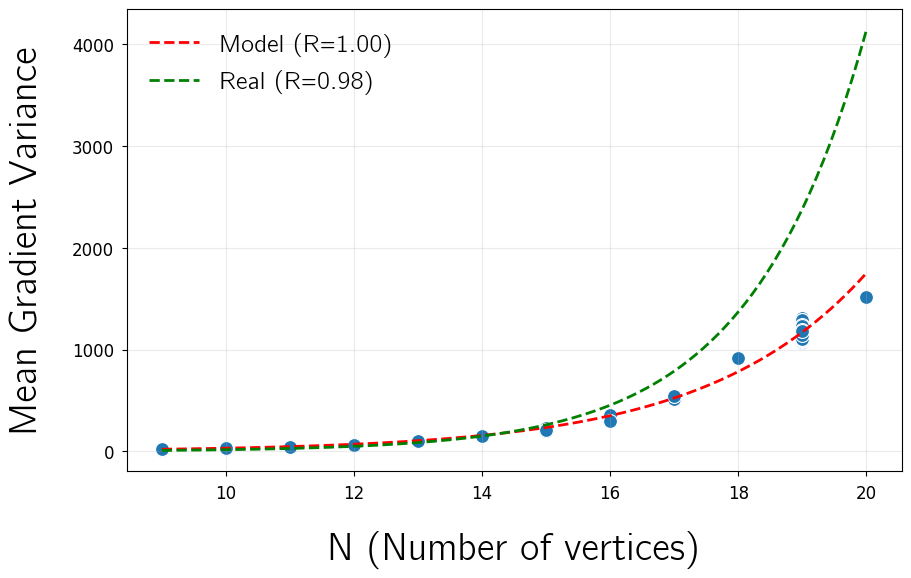

Edge density cluster_9 p = 5


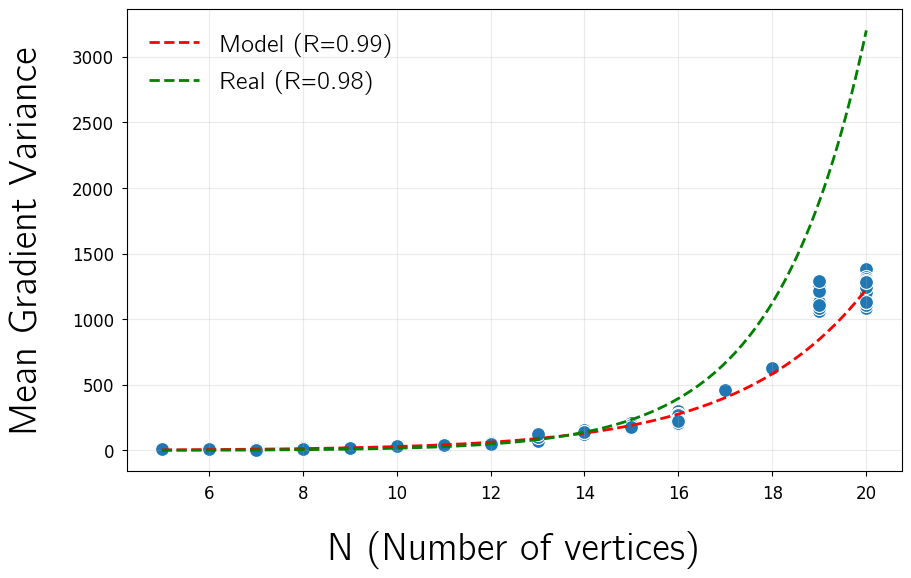

Harmonic diameter cluster_13 p = 5


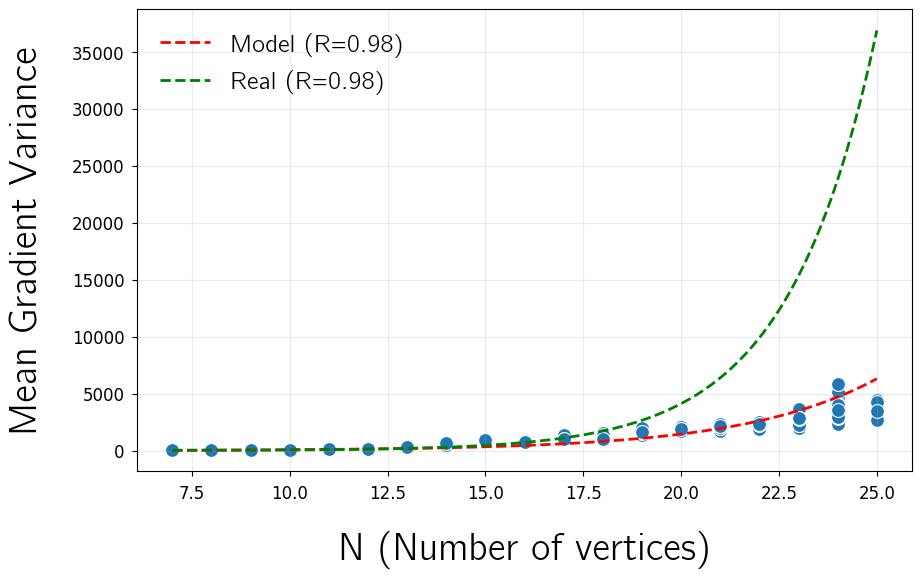

Edge density cluster_16 p = 1


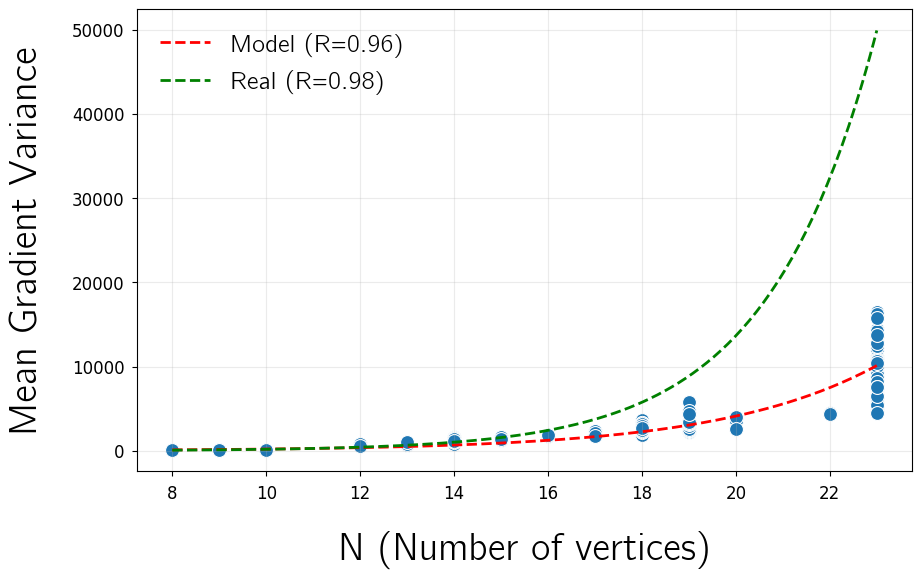

Edge density cluster_3 p = 1


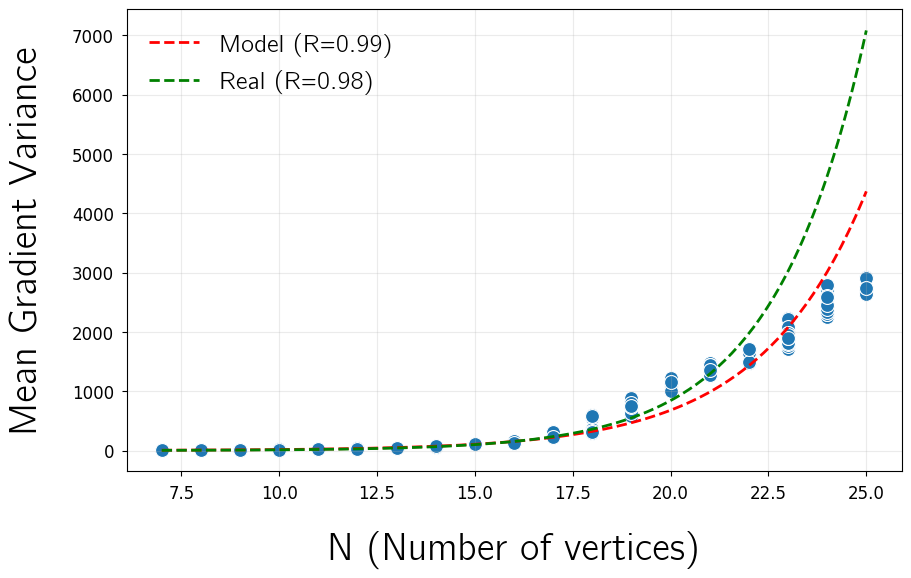

Edge density cluster_16 p = 3


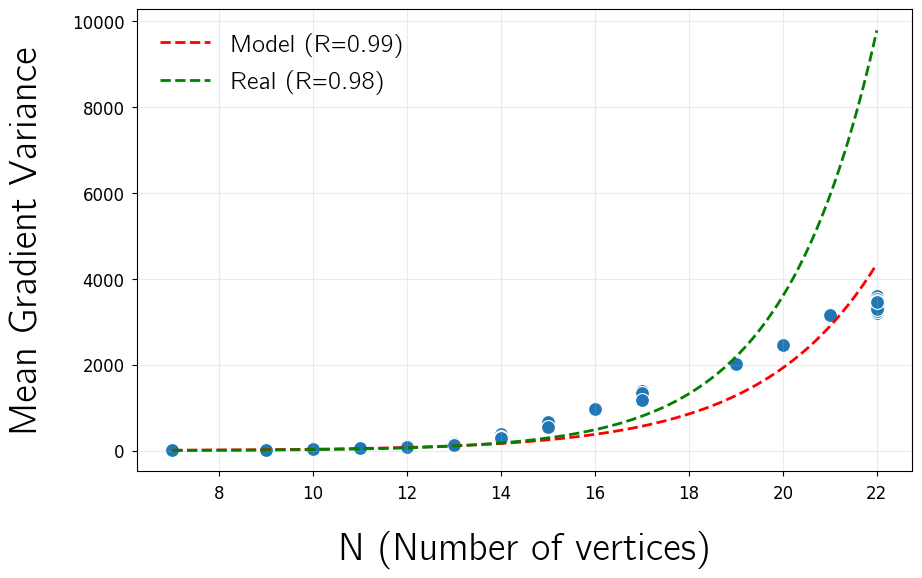

Edge density cluster_5 p = 3


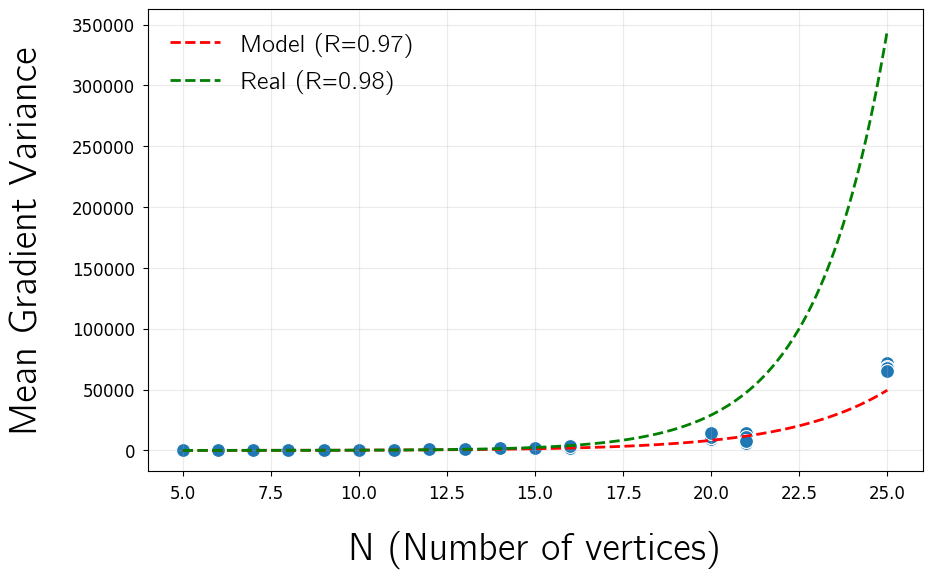

Harmonic diameter cluster_11 p = 1


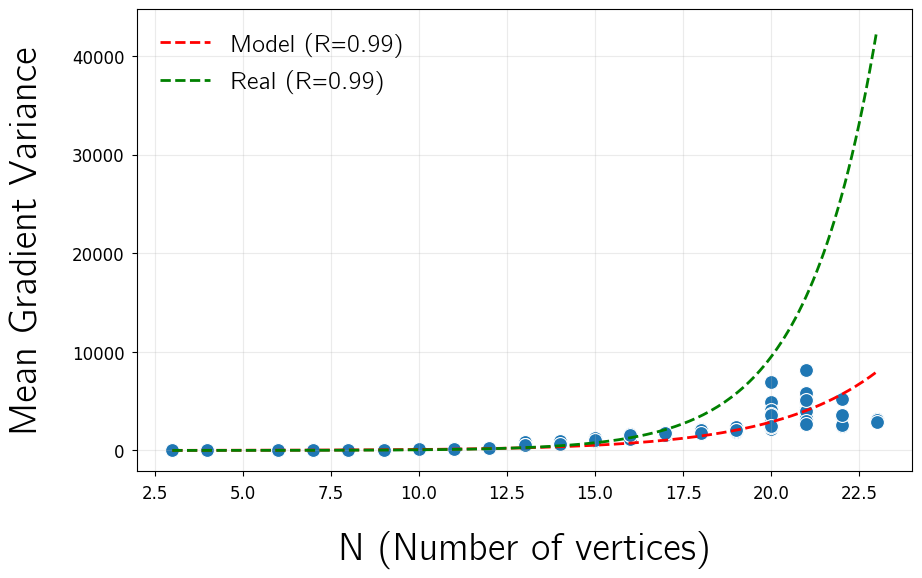

Edge density cluster_12 p = 1


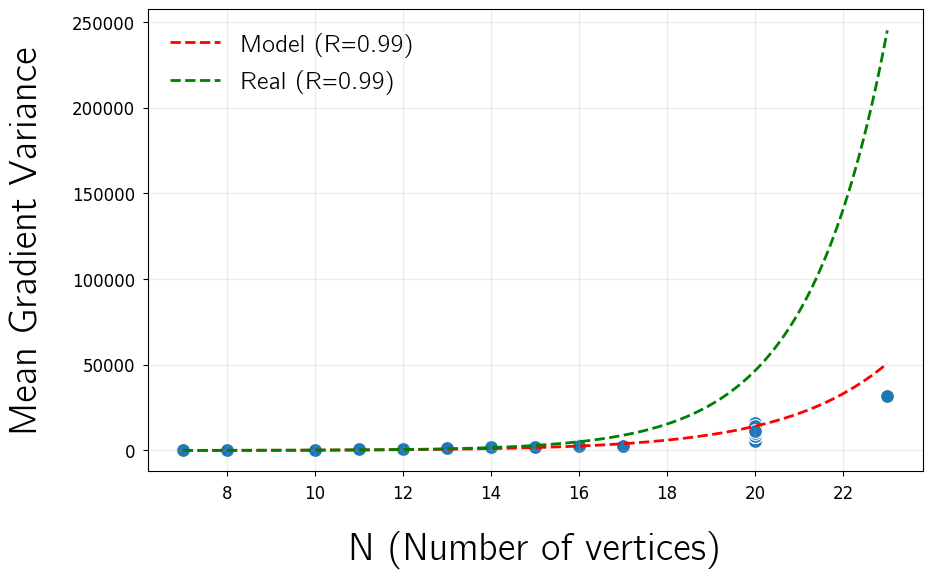

Edge density cluster_9 p = 1


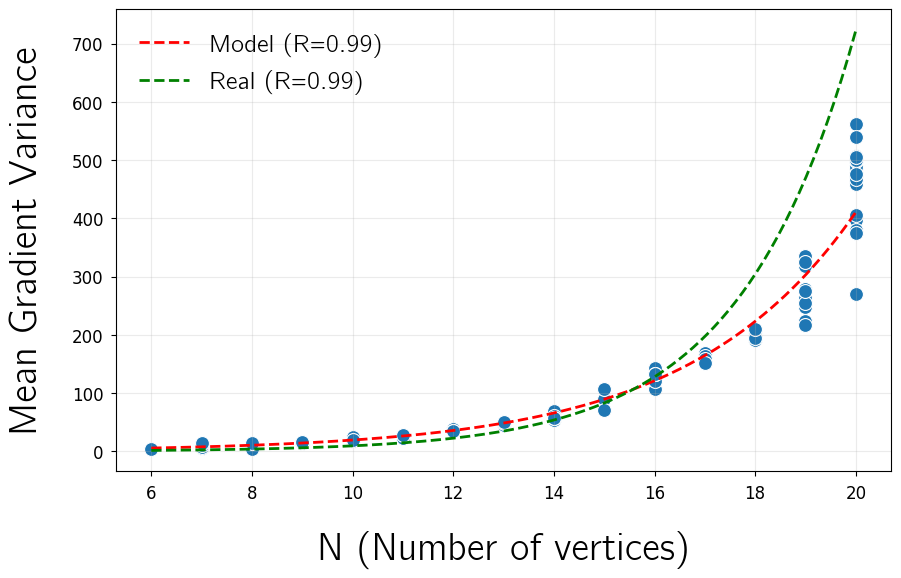

Harmonic diameter cluster_7 p = 5


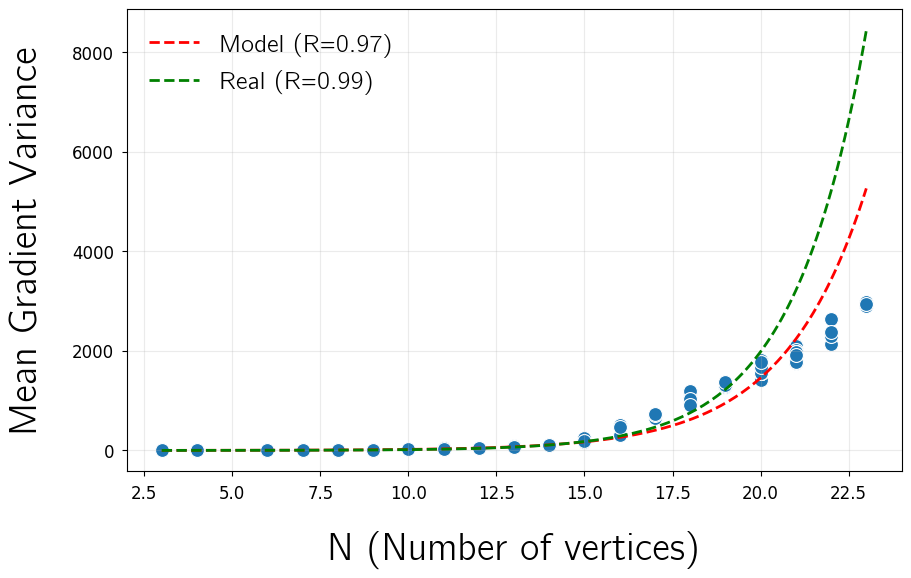

Edge density cluster_12 p = 3


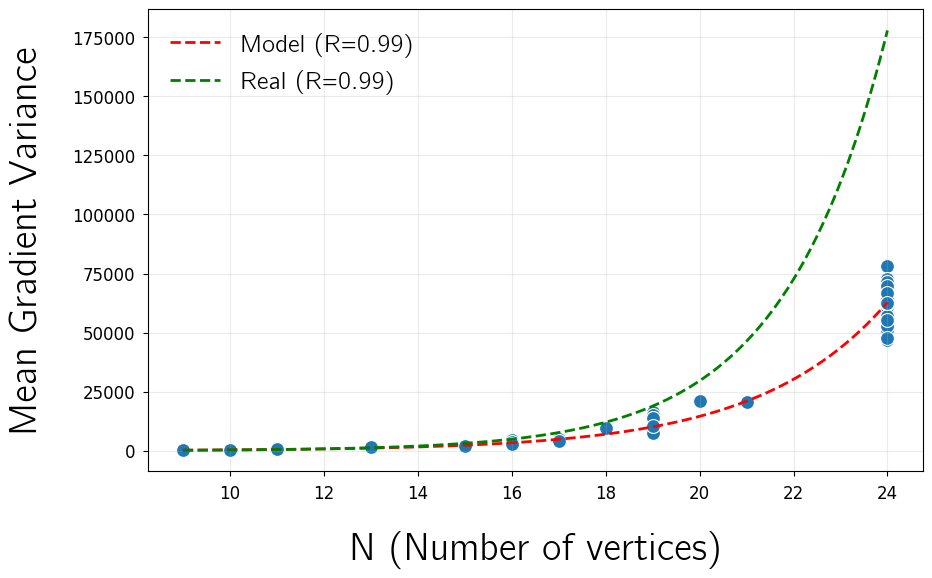

Edge density cluster_8 p = 1


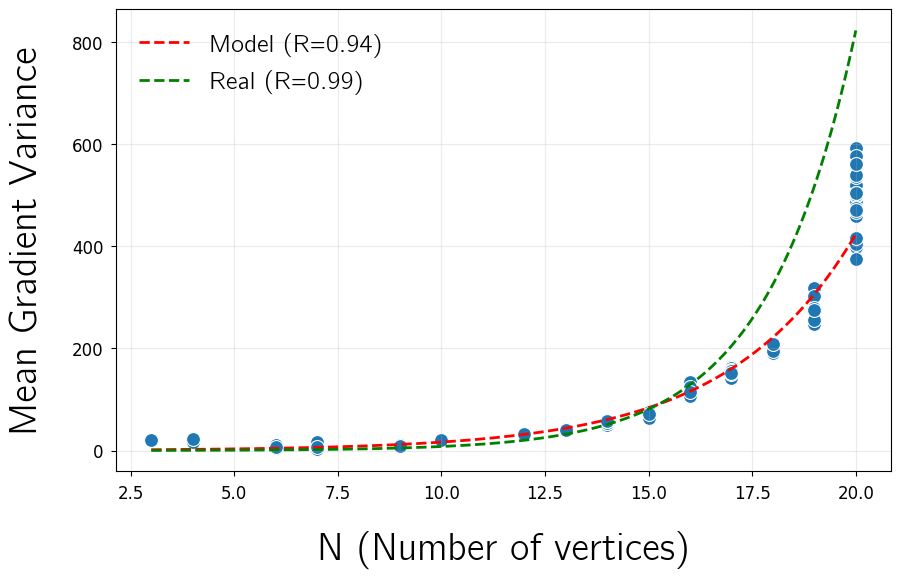

Edge density cluster_14 p = 5


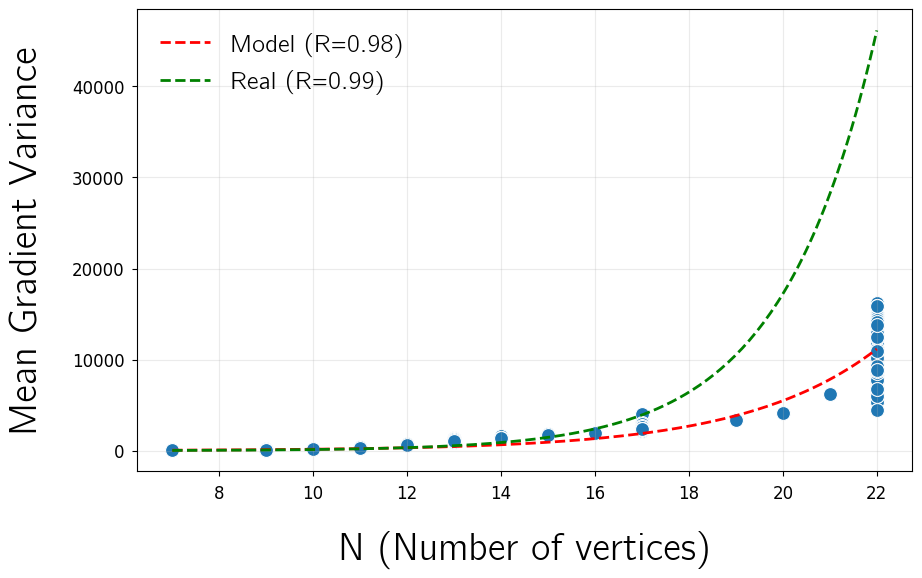

Edge density cluster_5 p = 1


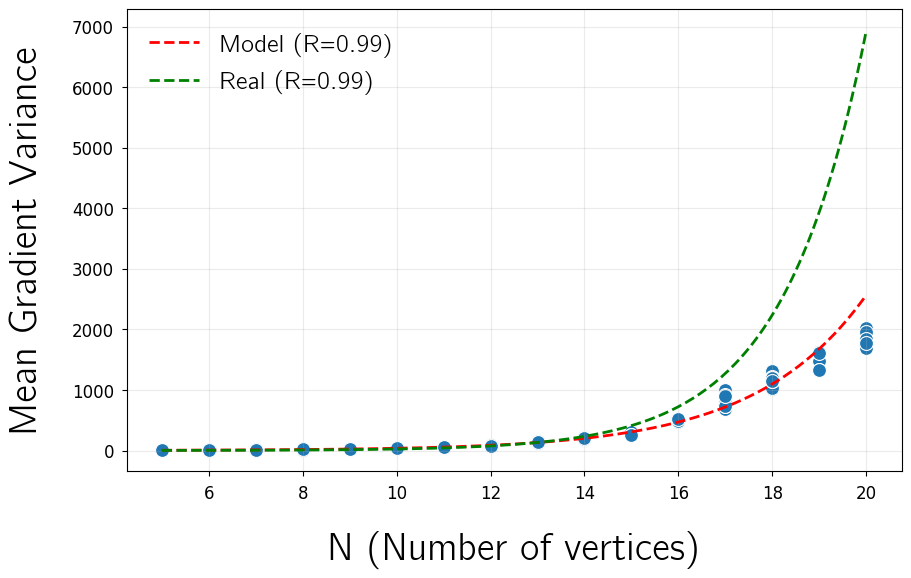

Harmonic diameter cluster_14 p = 5


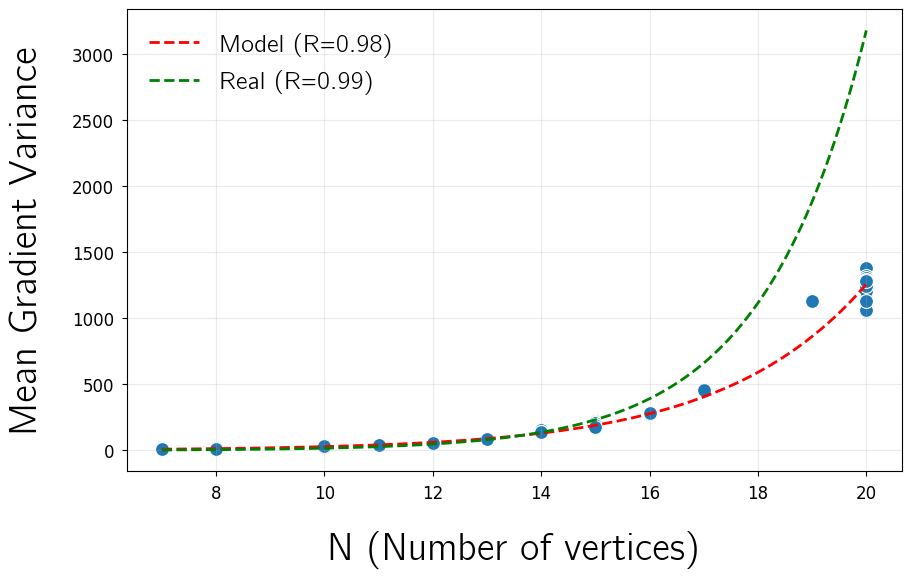

Edge density cluster_10 p = 5


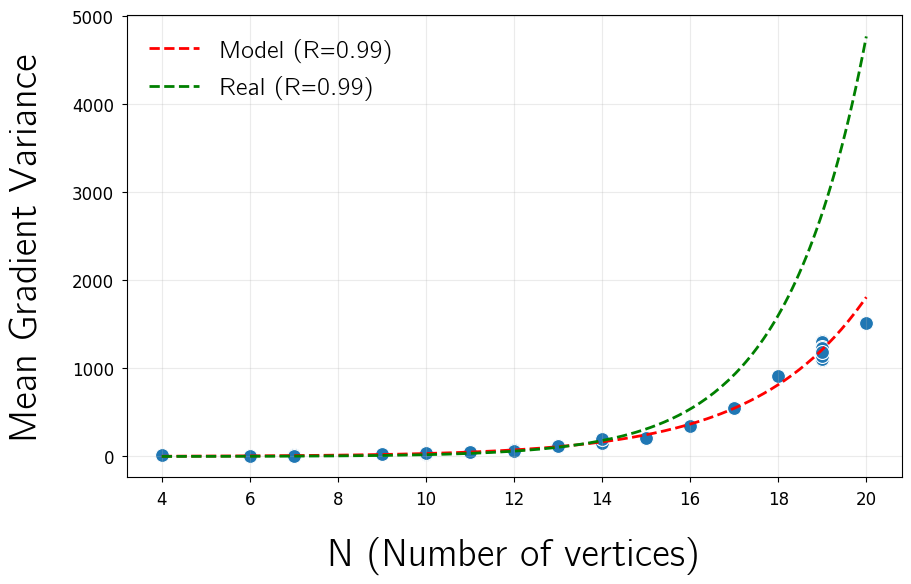

Harmonic diameter cluster_15 p = 5


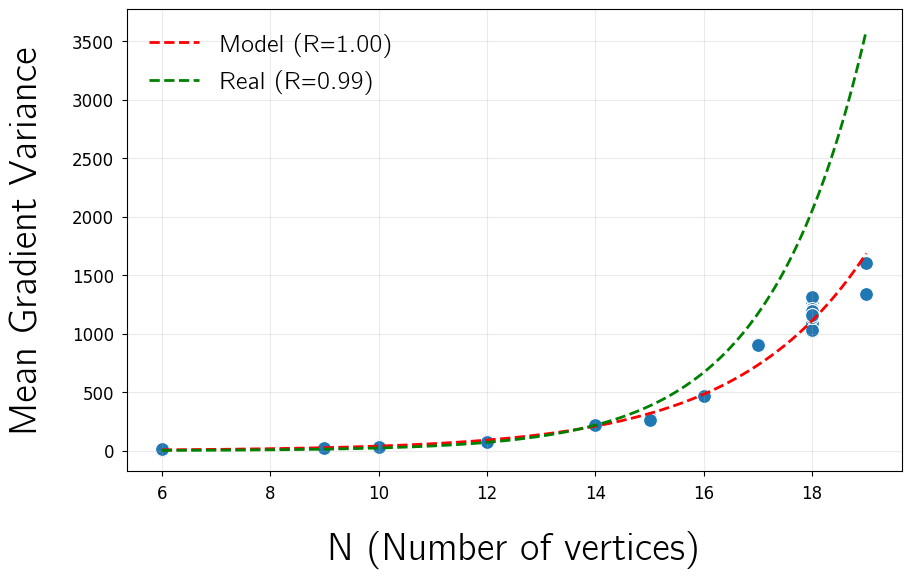

Edge density cluster_12 p = 5
0.02405649437169865


In [ ]:
r_mpe = 0
fit_mpe = 0

for index in range(len(big_list)):

  pred = big_list[index][1]
  n_vals = big_list[index][2]
  pred, n_vals = zip(*[(p, n) for p, n in zip(pred, n_vals) if p >= 0])
  pred, n_vals = list(pred), list(n_vals)
  label = big_list[index][0]
  prl = big_list[index][3]
  exp_a = big_list[index][4]
  exp_b = big_list[index][5]


  log_y = np.log(pred)

  slope, intercept, r, _, _ = linregress(n_vals, log_y)

  if not np.isnan(r):
    r_mpe += abs(r-prl) / abs(prl)

  fit_mpe += 0.5 * ((abs(exp_a - np.exp(intercept)) / exp_a) + (abs(exp_b - slope) / exp_b))

  x_fit = np.linspace(min(n_vals), max(n_vals), 200)
  y_fit = np.exp(intercept + slope * x_fit)
  true_y_fit = exp_a * np.exp(exp_b * x_fit)


  font_prop = fm.FontProperties(fname='cmunbmr.ttf', size=18) # replace with actual path

  with plt.style.context('seaborn-v0_8-paper'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=n_vals, y=pred, s=100)
    plt.plot(x_fit, y_fit, color="red", linestyle="--", linewidth=2, label=f"Model (R={r:.3f})")
    plt.plot(x_fit, true_y_fit, color="green", linestyle="--", linewidth=2, label=f"Real (R={prl:.3f})")

    # if plotting a fitted curve, use linestyle='--', linewidth=3
    # if plotting error bar, use fmt='o', capsize=12, ecolor='black', elinewidth=1
    plt.xlabel('N (Number of vertices)', fontsize=27, fontproperties=font_prop, labelpad=20)
    plt.ylabel('Mean Gradient Variance', fontsize=27, fontproperties=font_prop, labelpad=20)
    plt.grid(True, alpha=.25)
    plt.tick_params(axis='both', labelsize=12)
    plt.legend(fontsize=12, prop=font_prop, frameon=False, loc="best")
    plt.show()
    print(label)

And we can see the mean percent error for the real vs prediction Pearson correlation coefficients:

In [ ]:
print("mean percent error:", r_mpe / len(big_list))